In [2]:
import os
from functools import reduce
#accompanying botorch with torch for tensor operations
import torch
import random
import numpy as np
import pandas as pd
#botorch models
from botorch.models import SingleTaskGP, HeteroskedasticSingleTaskGP
#botorch fit function
from botorch.fit import fit_gpytorch_mll
#botorch acquisition
from botorch.acquisition import UpperConfidenceBound,qUpperConfidenceBound
#botorch acquisition optimization function (gradient)
from botorch.optim import optimize_acqf
#botorch sobol sampling
from botorch.utils.sampling import draw_sobol_samples
#get marginal log likelihood, it has to be maximised?
from gpytorch.mlls import ExactMarginalLogLikelihood
#plotting tools
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
#scikit-learn utilities
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from botorch.models.model_list_gp_regression import ModelListGP

In [3]:
#discover font, check if it's working
from matplotlib import font_manager

font_dirs = ['./']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Roboto'

In [4]:
plt.rc('font', family='Roboto')

In [5]:
#define device and dtype
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float64

In [6]:
#define seed for all packages
seed = 1245

# python RNG
random.seed(seed)

# pytorch RNGs
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
np.random.seed(seed)

In [7]:
#preprocessing OD tables, since they come from another script

In [8]:
#retrieving values for max_OD tables for each iteration
max_grow=[i for i in os.listdir() if ("max_table" in i) and (i.endswith(".csv"))]
#sort the tables' names to get the iterations in order
max_grow=sorted(max_grow)
#read and concatenate the max_OD tables
max_table_grow=reduce(lambda x,y: pd.concat([x,y]),[pd.read_csv(j) for j in max_grow])
#sort by iteration number and x1 (Glucose)
#everything should be ordered by glucose concentration to make it more standard
max_table_grow=max_table_grow.sort_values(["iteration","x1"])
#asigning arm names, it works for this table in specific, make it general?
max_table_grow["arm_name"]=["REF","0_1","0_2","0_3","0_4","0_5","0_6","0_7","1_1","REF","1_2","1_3","1_4","1_5","1_6","1_7",
                            "REF","2_1","2_2","2_3","2_4","2_5","2_6","2_7"]
#remove REF samples values and drop concentration values and iteration numbers, we will keep just the sample/arm labels
max_table_grow=max_table_grow.loc[max_table_grow["arm_name"]!="REF"].copy().drop(["x1","x2","iteration"],axis=1)
#assign molcule column with Max_OD as value
max_table_grow["molecule"]="Max_OD"
#extract the insteresting columns
max_table_grow=max_table_grow[['arm_name', 'molecule', 'mean', 'sem']].copy().reset_index(drop=True)
#pivot the tables to obtain a matrix, where the entries values in the matrix is the mean value for each sample measurement
max_matrix=max_table_grow.pivot(columns="molecule",index="arm_name",values="mean").reset_index()

In [9]:
#similar processing that max_OD
last_grow=[i for i in os.listdir() if ("last_table" in i) and (i.endswith(".csv"))]
last_grow=sorted(last_grow)
last_table_grow=reduce(lambda x,y: pd.concat([x,y]),[pd.read_csv(j) for j in last_grow])
last_table_grow=last_table_grow.sort_values(["iteration","x1"])
last_table_grow["arm_name"]=["REF","0_1","0_2","0_3","0_4","0_5","0_6","0_7","1_1","REF","1_2","1_3","1_4","1_5","1_6","1_7",
                            "REF","2_1","2_2","2_3","2_4","2_5","2_6","2_7"]
last_table_grow=last_table_grow.loc[last_table_grow["arm_name"]!="REF"].copy().drop(["x1","x2","iteration"],axis=1)
last_table_grow["molecule"]="Last_OD"
last_table_grow=last_table_grow[['arm_name', 'molecule', 'mean', 'sem']].copy().reset_index(drop=True)
last_matrix=last_table_grow.pivot(columns="molecule",index="arm_name",values="mean").reset_index()

In [10]:
#get tables with the lipopeptide abundances
lipo=[i for i in os.listdir() if ("lipo" in i) and (i.endswith(".csv"))]
lipo=sorted(lipo)
#join tables
master_table_lipo=reduce(lambda x,y: pd.concat([x,y]),[pd.read_csv(j) for j in lipo])
#rename condition column to arm_name
master_table_lipo=master_table_lipo.rename({"condition":"arm_name"}, axis=1)

In [11]:
#get tables with "TCA"-cycle metabolites abundances
dat=[i for i in os.listdir() if ("TCA" in i) and (i.endswith(".csv"))]
dat=sorted(dat)

#get tables with glucose and nitrogen concentrations and the sample arm_name
mapi=[i for i in os.listdir() if ("sample" in i) and (i.endswith(".csv"))]
mapi=sorted(mapi)

#join tables
master_table=reduce(lambda x,y: pd.concat([x,y]),[pd.read_csv(j) for j in dat])
master_itera=reduce(lambda x,y: pd.concat([x,y]),[pd.read_csv(j) for j in mapi])
#rename condition column to arm_name
master_table=master_table.rename({"condition":"arm_name"}, axis=1)
master_itera=master_itera.sort_values("sample").rename({"sample":"arm_name"}, axis=1)

In [12]:
#now arm_name contains the universal labels

In [13]:
#new master_table concatenate the data from TCA metabolites, lipopeptides and growth
master_table=pd.concat([master_table,max_table_grow,last_table_grow,master_table_lipo], axis=0)

In [14]:
#remove molecule from master_table that didn't satisfy quality criteria
master_table=master_table.loc[~master_table["molecule"].isin(['D-glucose', 'Glucose_Na','Glucose_Na_b'])].copy()

In [15]:
#pivot just the lipopeptide table to get a matrix with arm_names(samples) rows, molecules as columns and mean values for entries in the matrix
matlipo=master_table_lipo.pivot(columns="molecule",index="arm_name",values="mean").reset_index()

In [16]:
#exactly the same, but for the master_table
forpcax=master_table.pivot(columns="molecule",index="arm_name",values="mean")
#create a copy
forpca=forpcax.copy()

In [17]:
#reset index to get arm_name column
forpcax=forpcax.reset_index()
#decided to call it for forpcax because it's the matrix that will be use for PCA, but it's also use in general for other methods
#since we reset the index, forpcax isn't a proper matrix, it's also contains the arm_name column
#since the format of the arm_name labels always start with the iteration, it can be easily extract
forpcax["iteration"]=forpcax["arm_name"].apply(lambda x:x[0])

In [18]:
#forpcax contains the matrix and these two extra columns, iteration and arm_name

In [19]:
#get best surfactin C value for each iteration
max_idx = forpcax.groupby('iteration')['SurfactinC'].idxmax()
df_best = forpcax.loc[max_idx].drop("arm_name",axis=1)

In [20]:
#custom functions to position labels in PCA plot
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.04, point['y']+.04, str(point['val']),fontsize=8)
def label_point_2(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.08, point['y']+.08, str(point['val']),fontsize=16)

In [21]:
#The chosen radius
#(x-0.133)^2+(y-0.208)^2=r^2
#given by this equation, we calculate 8 directions, and the points on the circle corresponding to that direction
dirpoints=[(0,0.233,0.208),(45,0.203,0.278),(90,0.133,0.308),(135,0.062,0.278),(180,0.033,0.208),(235,0.062,0.137),(270,0.133,0.108),(315,0.203,0.137)]

In [22]:
#molis=['(S)-Malate', '3-Phospho-D-glycerate', '6-Phosphogluconic acid',
#       'Biotin', 'Butyrate', 'Citrate', 'D-Fructose 6-phosphate', 'Isocitrate',
#       'L-Arginine', 'L-Histidine', 'L-Lactate', 'L-Phenylalanine',
#       'L-Threonine', 'L-Tryptophan', 'L-Valine',
#       'R-2,3-Dihydroxy-isovalerate',
#       'R-2,3-dihydroxy-3-methylpentanoate', 'Succinate']

In [23]:
#define gradient function with step 0.1 ??
def grad_f(x, y, norm=True):    
    dfdx = 1 + 0.1 * y
    dfdy = 0.1 * x
    if norm:
        norm = np.linalg.norm((dfdx, dfdy), axis=0)
        dfdx /= norm
        dfdy /= norm
    return dfdx, dfdy

/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


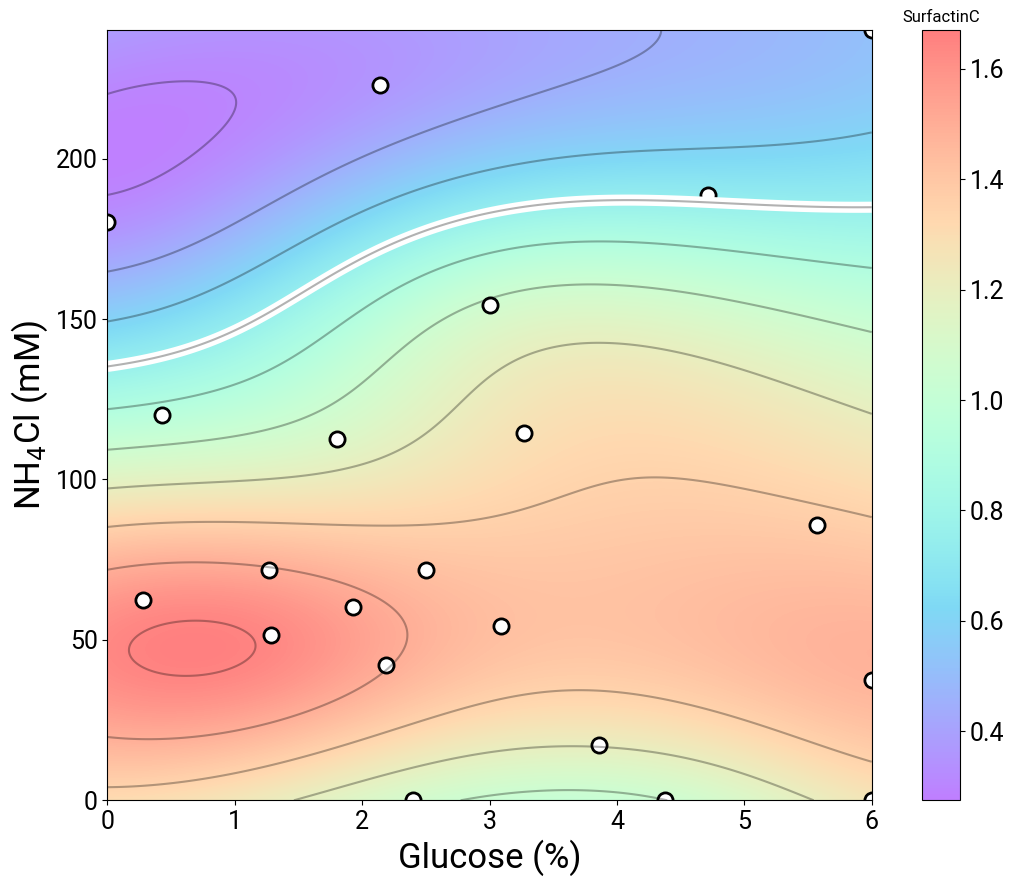

In [24]:
#plot one surface with the specifications
#create list for additional data, extra_points are the simulated points, directional are the radial grid points
extra_points=[]
directional=[]
for molecule in ["SurfactinC"]: #pd.unique(master_table["molecule"])
    #selecting one molecule
    tmptable=master_table.loc[master_table["molecule"]==molecule]
    #merge molecule data with arms
    ready_table=master_itera.merge(tmptable, on="arm_name")
    #extract iteration
    ready_table["iteration"]=ready_table["arm_name"].apply(lambda x: x[0])
    #take back to normalized values
    scaler = MinMaxScaler()
    scaler.fit(ready_table[["Glucose","NH4Cl"]].values)
    #define temporary number of samples, 7 combinations multiplied by the number of iterations, 3 in this case
    samples=7*3
    #create tensors for model training
    train_x=torch.from_numpy(scaler.transform(ready_table[["Glucose","NH4Cl"]].values))
    train_y=torch.from_numpy(ready_table["mean"].values).reshape(samples,1)
    observed_var=torch.from_numpy(ready_table["sem"].values).reshape(samples,1)
    #model training
    model = HeteroskedasticSingleTaskGP(train_X=train_x, train_Y=train_y,train_Yvar=observed_var)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    #torch.save(mll.model.state_dict(), molecule+'_model_state.pth')
    #create grid of points for visualization, define number of points, 1000 is a good number
    res=1001
    X_1 = np.linspace(0, 1, res)
    X_2 = np.linspace(0, 1, res)
    #creating grid
    xv,yv=np.meshgrid(X_1,X_2)
    xsys=np.column_stack((xv.flatten(),yv.flatten()))
    xsys2=torch.from_numpy(xsys)#.to(device)
    #making prediction, mcol is the mean, scol is the variance
    with torch.no_grad():
        #posterior = model.posterior(xsys2)
        predictive_posterior = mll.model.posterior(xsys2, observation_noise=True)
        mcol=predictive_posterior.mean
        scol=predictive_posterior.variance
        mcol2=mcol.reshape(res, -1).cpu().numpy()
        scol2=scol.reshape(res, -1).cpu().numpy()
    
        
    '''
    res_sm=21
    X_1_sm = np.linspace(0, 1, res_sm)
    X_2_sm = np.linspace(0, 1, res_sm)
    xv_sm,yv_sm=np.meshgrid(X_1_sm,X_2_sm)
    xsys_sm=np.column_stack((xv_sm.flatten(),yv_sm.flatten()))
    xsys2_sm=torch.from_numpy(xsys_sm)#.to(device)
    with torch.no_grad():
        #posterior = model.posterior(xsys2)
        predictive_posterior_sm = mll.model.posterior(xsys2_sm, observation_noise=True)
        mcol_sm=predictive_posterior_sm.mean
        scol_sm=predictive_posterior_sm.variance
        mcol2_sm=mcol_sm.reshape(res_sm, -1).cpu().numpy()
        scol2_sm=scol_sm.reshape(res_sm, -1).cpu().numpy()
    '''
    #radial grids for directional information
    for coord in dirpoints:
        res_sm=100
        X_1_sm = np.linspace(0.133, coord[1], res_sm)
        X_2_sm = np.linspace(0.208, coord[2], res_sm)
        #xv_sm,yv_sm=np.meshgrid(X_1_sm,X_2_sm)
        xsys_sm=np.column_stack((X_1_sm,X_2_sm))
        xsys2_sm=torch.from_numpy(xsys_sm)#.to(device)
        with torch.no_grad():
            #posterior = model.posterior(xsys2)
            predictive_posterior_sm = mll.model.posterior(xsys2_sm, observation_noise=True)
            mcol_sm=predictive_posterior_sm.mean
            scol_sm=predictive_posterior_sm.variance
            mcol2_sm=mcol_sm.reshape(res_sm, -1).cpu().numpy()
            scol2_sm=scol_sm.reshape(res_sm, -1).cpu().numpy()
        valdi=pd.DataFrame({"Glucose":(xsys2_sm.cpu().numpy())[:,0],"NH4Cl":(xsys2_sm.cpu().numpy())[:,1],molecule:mcol_sm.cpu().numpy().reshape(res_sm,)})
        directional.append([coord,valdi])  
   
    #dx, dy = np.gradient(mcol2_sm)
    #start plotting
    fig, ax = plt.subplots(figsize=(11,10))
    
    #making grid and mean predicted values as dataframe
    points=pd.DataFrame({"Glucose":(xsys2.cpu().numpy())[:,0],"NH4Cl":(xsys2.cpu().numpy())[:,1],molecule:mcol.cpu().numpy().reshape(res*res,)})
    extra_points.append(points)
    #valdi=pd.DataFrame({"Glucose":(xsys2_sm.cpu().numpy())[:,0],"NH4Cl":(xsys2_sm.cpu().numpy())[:,1],molecule:mcol_sm.cpu().numpy().reshape(res_sm,)})
    #directional.append(valdi)
    
    #generate level curves
    contours=ax.contour(xv*6,yv*240, mcol2,levels=[0.75],colors='white', linewidths=8)#, label='Noise-free objective')
    contours2=ax.contour(xv*6,yv*240, mcol2,11,colors='black',alpha=0.3)
    #contours3=ax.contour(xv*6,yv*240, mcol2,levels=[1.7],colors='black',alpha=0.3)
    #ax.clabel(contours,inline=True,fontsize=11)
    #label_point_2(ready_table["Glucose"],ready_table["NH4Cl"] ,ready_table["arm_name"].apply(lambda x: x[-1]), ax)
    im=ax.imshow(mcol2,extent=[0,6,0,240],origin='lower',cmap="rainbow",alpha=0.5,aspect='auto') #PRGnrainbow[0,6,0,240]#rainbow
    #dfdx, dfdy = grad_f(xv, yv)
    #qui=ax.quiver(xv_sm*6, yv_sm*240, dx, dy)
    m = ['o', 'x',"^"]

    for i in range(0,3):
        tempo=ready_table.loc[ready_table["iteration"]==str(i)].copy()
        if m[i]!="x":
            ax.scatter("Glucose","NH4Cl",marker="o",s=120,data=tempo,facecolors='white', edgecolors='black',linewidths=2,label="I"+str(i))
        else:
            ax.scatter("Glucose","NH4Cl",marker="o",s=120,data=tempo,facecolors='white', edgecolors='black',linewidths=2,label="I"+str(i)) #marker=m[i]#c="black"

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.5)
    cb=fig.colorbar(im, cax=cax)
    cb.ax.tick_params(labelsize=18)


    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.tick_params(axis='both', which='minor', labelsize=18)

    ax.set_xlabel("Glucose (%)",fontsize=25)
    ax.set_ylabel(r"NH$_{4}$Cl (mM)",fontsize=25)

    #ax.legend(loc=1, prop={'size': 15})
    plt.title(molecule)#"s.e.m"
    plt.show()
    #plt.savefig(molecule+"_surface_paper.jpg",bbox_inches="tight",dpi=400)
    plt.close()
    del model

In [25]:
import torch
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from statistics import mean
import numpy as np

In [26]:
#plot one surface with the specifications, perform k-fold cross-validation
#create list for additional data, extra_points are the simulated points, directional are the radial grid points

extra_points=[]
directional=[]
scorespandas=pd.DataFrame()
for molecule in pd.unique(master_table["molecule"]):
    #selecting one molecule
    tmptable=master_table.loc[master_table["molecule"]==molecule]
    #merge molecule data with arms
    ready_table=master_itera.merge(tmptable, on="arm_name")
    #extract iteration
    ready_table["iteration"]=ready_table["arm_name"].apply(lambda x: x[0])
    #take back to normalized values
    scaler = MinMaxScaler()
    scaler.fit(ready_table[["Glucose","NH4Cl"]].values)
    #define temporary number of samples, 7 combinations multiplied by the number of iterations, 3 in this case
    samples=7*3
    #create tensors for model training
    train_x=torch.from_numpy(scaler.transform(ready_table[["Glucose","NH4Cl"]].values))
    train_y=torch.from_numpy(ready_table["mean"].values).reshape(samples,1)
    observed_var=torch.from_numpy(ready_table["sem"].values).reshape(samples,1)
    #model training
    model = HeteroskedasticSingleTaskGP(train_X=train_x, train_Y=train_y,train_Yvar=observed_var)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    #torch.save(mll.model.state_dict(), molecule+'_model_state.pth')
    #create grid of points for visualization, define number of points, 1000 is a good number

    # Assuming ready_table is a pandas DataFrame
    samples = len(ready_table)
    k = 3  # Number of folds
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Placeholder for RMSE scores
    rmse_scores = []

    for train_index, test_index in kf.split(ready_table):
        # Splitting the data
        train, test = ready_table.iloc[train_index], ready_table.iloc[test_index]
    
        # Feature scaling
        scaler = StandardScaler().fit(train[["Glucose", "NH4Cl"]].values)
        train_x = torch.from_numpy(scaler.transform(train[["Glucose", "NH4Cl"]].values))
        test_x = torch.from_numpy(scaler.transform(test[["Glucose", "NH4Cl"]].values))
    
        # Preparing target variables
        train_y = torch.from_numpy(train["mean"].values).reshape(-1, 1)
        test_y = test["mean"].values
    
        # Preparing observed variance
        observed_var = torch.from_numpy(train["sem"].values).reshape(-1, 1)
    
        # Model training
        model = HeteroskedasticSingleTaskGP(train_X=train_x, train_Y=train_y, train_Yvar=observed_var)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)
    
        with torch.no_grad():
            predictive_posterior = mll.model.posterior(test_x, observation_noise=True)
            predictions = predictive_posterior.mean
            pre2=predictions.reshape(1,-1).cpu().numpy()
            rsme = np.sqrt(np.mean((pre2[0] - test_y) ** 2))
            #print(rsme)
        # Store the RMSE score
        rmse_scores.append(rsme.item())

    # Average RMSE across all folds
    print(rmse_scores)
    average_rmse = np.mean(rmse_scores)
    std_rmse = np.std(rmse_scores)
    print("Average RMSE: ", average_rmse)
    print("Std RMSE: ", std_rmse)
    scorespandas[molecule]=rmse_scores
    res=1001
    X_1 = np.linspace(0, 1, res)
    X_2 = np.linspace(0, 1, res)
    #creating grid
    xv,yv=np.meshgrid(X_1,X_2)
    xsys=np.column_stack((xv.flatten(),yv.flatten()))
    xsys2=torch.from_numpy(xsys)#.to(device)
    #making prediction, mcol is the mean, scol is the variance
    with torch.no_grad():
        #posterior = model.posterior(xsys2)
        predictive_posterior = mll.model.posterior(xsys2, observation_noise=True)
        mcol=predictive_posterior.mean
        scol=predictive_posterior.variance
        mcol2=mcol.reshape(res, -1).cpu().numpy()
        scol2=scol.reshape(res, -1).cpu().numpy()
    
        
    '''
    res_sm=21
    X_1_sm = np.linspace(0, 1, res_sm)
    X_2_sm = np.linspace(0, 1, res_sm)
    xv_sm,yv_sm=np.meshgrid(X_1_sm,X_2_sm)
    xsys_sm=np.column_stack((xv_sm.flatten(),yv_sm.flatten()))
    xsys2_sm=torch.from_numpy(xsys_sm)#.to(device)
    with torch.no_grad():
        #posterior = model.posterior(xsys2)
        predictive_posterior_sm = mll.model.posterior(xsys2_sm, observation_noise=True)
        mcol_sm=predictive_posterior_sm.mean
        scol_sm=predictive_posterior_sm.variance
        mcol2_sm=mcol_sm.reshape(res_sm, -1).cpu().numpy()
        scol2_sm=scol_sm.reshape(res_sm, -1).cpu().numpy()
    '''
    #radial grids for directional information
    for coord in dirpoints:
        res_sm=100
        X_1_sm = np.linspace(0.133, coord[1], res_sm)
        X_2_sm = np.linspace(0.208, coord[2], res_sm)
        #xv_sm,yv_sm=np.meshgrid(X_1_sm,X_2_sm)
        xsys_sm=np.column_stack((X_1_sm,X_2_sm))
        xsys2_sm=torch.from_numpy(xsys_sm)#.to(device)
        with torch.no_grad():
            #posterior = model.posterior(xsys2)
            predictive_posterior_sm = mll.model.posterior(xsys2_sm, observation_noise=True)
            mcol_sm=predictive_posterior_sm.mean
            scol_sm=predictive_posterior_sm.variance
            mcol2_sm=mcol_sm.reshape(res_sm, -1).cpu().numpy()
            scol2_sm=scol_sm.reshape(res_sm, -1).cpu().numpy()
        valdi=pd.DataFrame({"Glucose":(xsys2_sm.cpu().numpy())[:,0],"NH4Cl":(xsys2_sm.cpu().numpy())[:,1],molecule:mcol_sm.cpu().numpy().reshape(res_sm,)})
        directional.append([coord,valdi])  
    '''
    #dx, dy = np.gradient(mcol2_sm)
    #start plotting
    fig, ax = plt.subplots(figsize=(11,10))
    
    #making grid and mean predicted values as dataframe
    points=pd.DataFrame({"Glucose":(xsys2.cpu().numpy())[:,0],"NH4Cl":(xsys2.cpu().numpy())[:,1],molecule:mcol.cpu().numpy().reshape(res*res,)})
    extra_points.append(points)
    #valdi=pd.DataFrame({"Glucose":(xsys2_sm.cpu().numpy())[:,0],"NH4Cl":(xsys2_sm.cpu().numpy())[:,1],molecule:mcol_sm.cpu().numpy().reshape(res_sm,)})
    #directional.append(valdi)
    
    #generate level curves
    contours=ax.contour(xv*6,yv*240, mcol2,levels=[0.75],colors='white', linewidths=8)#, label='Noise-free objective')
    contours2=ax.contour(xv*6,yv*240, mcol2,11,colors='black',alpha=0.3)
    #contours3=ax.contour(xv*6,yv*240, mcol2,levels=[1.7],colors='black',alpha=0.3)
    #ax.clabel(contours,inline=True,fontsize=11)
    #label_point_2(ready_table["Glucose"],ready_table["NH4Cl"] ,ready_table["arm_name"].apply(lambda x: x[-1]), ax)
    im=ax.imshow(mcol2,extent=[0,6,0,240],origin='lower',cmap="rainbow",alpha=0.5,aspect='auto') #PRGnrainbow[0,6,0,240]#rainbow
    #dfdx, dfdy = grad_f(xv, yv)
    #qui=ax.quiver(xv_sm*6, yv_sm*240, dx, dy)
    m = ['o', 'x',"^"]

    for i in range(0,3):
        tempo=ready_table.loc[ready_table["iteration"]==str(i)].copy()
        if m[i]!="x":
            ax.scatter("Glucose","NH4Cl",marker="o",s=120,data=tempo,facecolors='white', edgecolors='black',linewidths=2,label="I"+str(i))
        else:
            ax.scatter("Glucose","NH4Cl",marker="o",s=120,data=tempo,facecolors='white', edgecolors='black',linewidths=2,label="I"+str(i)) #marker=m[i]#c="black"

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.5)
    cb=fig.colorbar(im, cax=cax)
    cb.ax.tick_params(labelsize=18)


    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.tick_params(axis='both', which='minor', labelsize=18)

    ax.set_xlabel("Glucose (%)",fontsize=25)
    ax.set_ylabel(r"NH$_{4}$Cl (mM)",fontsize=25)

    #ax.legend(loc=1, prop={'size': 15})
    plt.title(molecule)#"s.e.m"
    plt.show()
    #plt.savefig(molecule+"_surface_paper.jpg",bbox_inches="tight",dpi=400)
    plt.close()
    '''
    del model
    

/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube.

[0.5544980519302495, 0.8585153765518012, 0.4072442366025289]
Average RMSE:  0.6067525550281931
Std RMSE:  0.18789945938948074


/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube.

[0.5211610891607147, 0.25194010053382787, 0.5045853840936012]
Average RMSE:  0.4258955245960479
Std RMSE:  0.12319105938911337


/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube.

[0.11882270210401194, 0.30218493603374125, 0.18523701482960728]
Average RMSE:  0.20208155098912017
Std RMSE:  0.07579899298692143


/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube.

[0.21062758171157275, 0.10448615051901634, 0.25852978424824546]
Average RMSE:  0.19121450549294483
Std RMSE:  0.06436878601376558


/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube.

[0.10808363573515861, 0.0881910566770618, 0.20203733872181442]
Average RMSE:  0.13277067704467826
Std RMSE:  0.04964763499111707


/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube.

[0.11988230960986783, 0.21254850205225562, 0.3163632316647272]
Average RMSE:  0.21626468110895022
Std RMSE:  0.08025603060608796


/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube.

[0.28157471589855665, 0.3466083261672303, 0.4721148269937863]
Average RMSE:  0.3667659563531911
Std RMSE:  0.07908278795069162


/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube.

[0.0772984000092261, 0.1594904472619525, 0.16612393551460633]
Average RMSE:  0.13430426092859496
Std RMSE:  0.040400098398958924


/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube.

[1.5947863634846593, 2.1435316901779147, 1.783376258382604]
Average RMSE:  1.840564770681726
Std RMSE:  0.22764482986465562


/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube.

[0.27190188608412424, 0.36541559751000896, 0.35735895500072323]
Average RMSE:  0.33155881286495215
Std RMSE:  0.042311850639668344


/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube.

[0.17474408919294304, 0.11557416148417986, 0.3444888743735342]
Average RMSE:  0.2116023750168857
Std RMSE:  0.09702022596590697


/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube.

[1.7402226481234193, 1.561538529869304, 1.3429752614357517]
Average RMSE:  1.548245479809492
Std RMSE:  0.16244773609269914


/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube.

[0.3703243886887064, 0.4173941415832163, 0.38908526166557095]
Average RMSE:  0.3922679306458312
Std RMSE:  0.01934747952173598


/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube.

[0.1640085620365033, 0.07122657893731543, 0.14068756589504075]
Average RMSE:  0.1253075689562865
Std RMSE:  0.03940839442159131


/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube.

[0.38928095440098454, 0.474048029621542, 0.3925664461176857]
Average RMSE:  0.41863181004673744
Std RMSE:  0.03920813400241796


/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube.

[0.3955672234128487, 0.5740197762638776, 0.26254520388130015]
Average RMSE:  0.41071073451934215
Std RMSE:  0.12760902987041245


/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube.

[0.6272949560366603, 0.30891651116252455, 0.4719203290731282]
Average RMSE:  0.46937726542410435
Std RMSE:  0.12998989427300495


/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube.

[0.6114257492319334, 1.0252666608676209, 0.433438641055237]
Average RMSE:  0.6900436837182639
Std RMSE:  0.24792564204607068


/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube.

[0.11350989977137085, 0.12112483483113662, 0.06805096671349209]
Average RMSE:  0.10089523377199987
Std RMSE:  0.023431548788603315


/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube.

[0.15855107068634217, 0.1985536316687055, 0.24217986647671155]
Average RMSE:  0.19976152294391972
Std RMSE:  0.03415199479128933


/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube.

[0.45202475589345215, 0.8190365934388631, 0.5882124152306772]
Average RMSE:  0.6197579215209975
Std RMSE:  0.15148324758852436


/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube.

[0.5136811244854884, 0.4760230004281051, 0.5872289976605519]
Average RMSE:  0.5256443741913818
Std RMSE:  0.046181042017693165


/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube.

[0.6398940012013773, 0.7392832184360939, 0.5613504007306677]
Average RMSE:  0.646842540122713
Std RMSE:  0.07280674670662556


/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube.

[0.5254197148100187, 0.9028758807943925, 0.6491812638153917]
Average RMSE:  0.6924922864732675
Std RMSE:  0.15710967044850987


In [27]:
#plot one surface with the specifications, perform LOO cross-validation
#create list for additional data, extra_points are the simulated points, directional are the radial grid points

extra_points=[]
directional=[]
scorespandas=pd.DataFrame()
for molecule in ["SurfactinC"]:#pd.unique(master_table["molecule"]):
    #selecting one molecule
    tmptable=master_table.loc[master_table["molecule"]==molecule]
    #merge molecule data with arms
    ready_table=master_itera.merge(tmptable, on="arm_name")
    if molecule=="SurfactinC":
        chequi=ready_table
    #extract iteration
    ready_table["iteration"]=ready_table["arm_name"].apply(lambda x: x[0])
    #print(ready_table["iteration"])
    ready_table=ready_table.loc[ready_table["iteration"]!="2"]
    #print(ready_table)
    #take back to normalized values
    scaler = MinMaxScaler()
    scaler.fit(ready_table[["Glucose","NH4Cl"]].values)
    #define temporary number of samples, 7 combinations multiplied by the number of iterations, 3 in this case
    samples=7*2
    #create tensors for model training
    train_x=torch.from_numpy(scaler.transform(ready_table[["Glucose","NH4Cl"]].values))
    train_y=torch.from_numpy(ready_table["mean"].values).reshape(samples,1)
    observed_var=torch.from_numpy(ready_table["sem"].values).reshape(samples,1)
    #model training
    model = HeteroskedasticSingleTaskGP(train_X=train_x, train_Y=train_y,train_Yvar=observed_var)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    #torch.save(mll.model.state_dict(), molecule+'_model_state.pth')
    #create grid of points for visualization, define number of points, 1000 is a good number

    # Assuming ready_table is a pandas DataFrame
    samples = len(ready_table)

    kf = KFold(n_splits=samples, shuffle=True, random_state=42) #LOO is equal to k-fold when k is the total number of samples

    # Placeholder for RMSE scores
    rmse_scores = []

    for train_index, test_index in kf.split(ready_table):
        # Splitting the data
        train, test = ready_table.iloc[train_index], ready_table.iloc[test_index]
    
        # Feature scaling
        #scaler = StandardScaler().fit(train[["Glucose", "NH4Cl"]].values)
        train_x = torch.from_numpy(train[["Glucose", "NH4Cl"]].values)
        test_x = torch.from_numpy(test[["Glucose", "NH4Cl"]].values)
    
        # Preparing target variables
        train_y = torch.from_numpy(train["mean"].values).reshape(-1, 1)
        test_y = test["mean"].values
    
        # Preparing observed variance
        observed_var = torch.from_numpy(train["sem"].values).reshape(-1, 1)
    
        # Model training
        model = HeteroskedasticSingleTaskGP(train_X=train_x, train_Y=train_y, train_Yvar=observed_var)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)
    
        with torch.no_grad():
            predictive_posterior = mll.model.posterior(test_x, observation_noise=True)
            predictions = predictive_posterior.mean
            pre2=predictions.reshape(1,-1).cpu().numpy()
            rsme = np.sqrt(np.mean((pre2[0] - test_y) ** 2))
            #print(rsme)
        # Store the RMSE score
        rmse_scores.append(rsme.item())

    # Average RMSE across all folds
    print(rmse_scores)
    average_rmse = np.mean(rmse_scores)
    std_rmse = np.std(rmse_scores)
    print("Average RMSE: ", average_rmse)
    print("Std RMSE: ", std_rmse)
    scorespandas[molecule]=rmse_scores
    res=1001
    X_1 = np.linspace(0, 1, res)
    X_2 = np.linspace(0, 1, res)
    #creating grid
    xv,yv=np.meshgrid(X_1,X_2)
    xsys=np.column_stack((xv.flatten(),yv.flatten()))
    xsys2=torch.from_numpy(xsys)#.to(device)
    #making prediction, mcol is the mean, scol is the variance
    with torch.no_grad():
        #posterior = model.posterior(xsys2)
        predictive_posterior = mll.model.posterior(xsys2, observation_noise=True)
        mcol=predictive_posterior.mean
        scol=predictive_posterior.variance
        mcol2=mcol.reshape(res, -1).cpu().numpy()
        scol2=scol.reshape(res, -1).cpu().numpy()
    
        
    '''
    res_sm=21
    X_1_sm = np.linspace(0, 1, res_sm)
    X_2_sm = np.linspace(0, 1, res_sm)
    xv_sm,yv_sm=np.meshgrid(X_1_sm,X_2_sm)
    xsys_sm=np.column_stack((xv_sm.flatten(),yv_sm.flatten()))
    xsys2_sm=torch.from_numpy(xsys_sm)#.to(device)
    with torch.no_grad():
        #posterior = model.posterior(xsys2)
        predictive_posterior_sm = mll.model.posterior(xsys2_sm, observation_noise=True)
        mcol_sm=predictive_posterior_sm.mean
        scol_sm=predictive_posterior_sm.variance
        mcol2_sm=mcol_sm.reshape(res_sm, -1).cpu().numpy()
        scol2_sm=scol_sm.reshape(res_sm, -1).cpu().numpy()
    '''
    #radial grids for directional information
    for coord in dirpoints:
        res_sm=100
        X_1_sm = np.linspace(0.133, coord[1], res_sm)
        X_2_sm = np.linspace(0.208, coord[2], res_sm)
        #xv_sm,yv_sm=np.meshgrid(X_1_sm,X_2_sm)
        xsys_sm=np.column_stack((X_1_sm,X_2_sm))
        xsys2_sm=torch.from_numpy(xsys_sm)#.to(device)
        with torch.no_grad():
            #posterior = model.posterior(xsys2)
            predictive_posterior_sm = mll.model.posterior(xsys2_sm, observation_noise=True)
            mcol_sm=predictive_posterior_sm.mean
            scol_sm=predictive_posterior_sm.variance
            mcol2_sm=mcol_sm.reshape(res_sm, -1).cpu().numpy()
            scol2_sm=scol_sm.reshape(res_sm, -1).cpu().numpy()
        valdi=pd.DataFrame({"Glucose":(xsys2_sm.cpu().numpy())[:,0],"NH4Cl":(xsys2_sm.cpu().numpy())[:,1],molecule:mcol_sm.cpu().numpy().reshape(res_sm,)})
        directional.append([coord,valdi])  
    '''
    #dx, dy = np.gradient(mcol2_sm)
    #start plotting
    fig, ax = plt.subplots(figsize=(11,10))
    
    #making grid and mean predicted values as dataframe
    points=pd.DataFrame({"Glucose":(xsys2.cpu().numpy())[:,0],"NH4Cl":(xsys2.cpu().numpy())[:,1],molecule:mcol.cpu().numpy().reshape(res*res,)})
    extra_points.append(points)
    #valdi=pd.DataFrame({"Glucose":(xsys2_sm.cpu().numpy())[:,0],"NH4Cl":(xsys2_sm.cpu().numpy())[:,1],molecule:mcol_sm.cpu().numpy().reshape(res_sm,)})
    #directional.append(valdi)
    
    #generate level curves
    contours=ax.contour(xv*6,yv*240, mcol2,levels=[0.75],colors='white', linewidths=8)#, label='Noise-free objective')
    contours2=ax.contour(xv*6,yv*240, mcol2,11,colors='black',alpha=0.3)
    #contours3=ax.contour(xv*6,yv*240, mcol2,levels=[1.7],colors='black',alpha=0.3)
    #ax.clabel(contours,inline=True,fontsize=11)
    #label_point_2(ready_table["Glucose"],ready_table["NH4Cl"] ,ready_table["arm_name"].apply(lambda x: x[-1]), ax)
    im=ax.imshow(mcol2,extent=[0,6,0,240],origin='lower',cmap="rainbow",alpha=0.5,aspect='auto') #PRGnrainbow[0,6,0,240]#rainbow
    #dfdx, dfdy = grad_f(xv, yv)
    #qui=ax.quiver(xv_sm*6, yv_sm*240, dx, dy)
    m = ['o', 'x',"^"]

    for i in range(0,3):
        tempo=ready_table.loc[ready_table["iteration"]==str(i)].copy()
        if m[i]!="x":
            ax.scatter("Glucose","NH4Cl",marker="o",s=120,data=tempo,facecolors='white', edgecolors='black',linewidths=2,label="I"+str(i))
        else:
            ax.scatter("Glucose","NH4Cl",marker="o",s=120,data=tempo,facecolors='white', edgecolors='black',linewidths=2,label="I"+str(i)) #marker=m[i]#c="black"

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.5)
    cb=fig.colorbar(im, cax=cax)
    cb.ax.tick_params(labelsize=18)


    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.tick_params(axis='both', which='minor', labelsize=18)

    ax.set_xlabel("Glucose (%)",fontsize=25)
    ax.set_ylabel(r"NH$_{4}$Cl (mM)",fontsize=25)

    #ax.legend(loc=1, prop={'size': 15})
    plt.title(molecule)#"s.e.m"
    plt.show()
    #plt.savefig(molecule+"_surface_paper.jpg",bbox_inches="tight",dpi=400)
    plt.close()
    '''
    del model
    

/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube.

[0.13722585815573107, 0.14886095479577177, 0.3651360352002275, 0.0010527720074180458, 0.7747780926409837, 0.06958161859838485, 1.1744619971855992, 1.3779086818488284, 0.10174885059100736, 0.32861212465446643, 0.43063805120517284, 0.043210547404195276, 0.2619048093991043, 0.023074975619413962]
Average RMSE:  0.3741568120933074
Std RMSE:  0.42023013322418085


In [28]:
scorespandas.to_csv("scores_loo_nonscaled.csv",index=False)

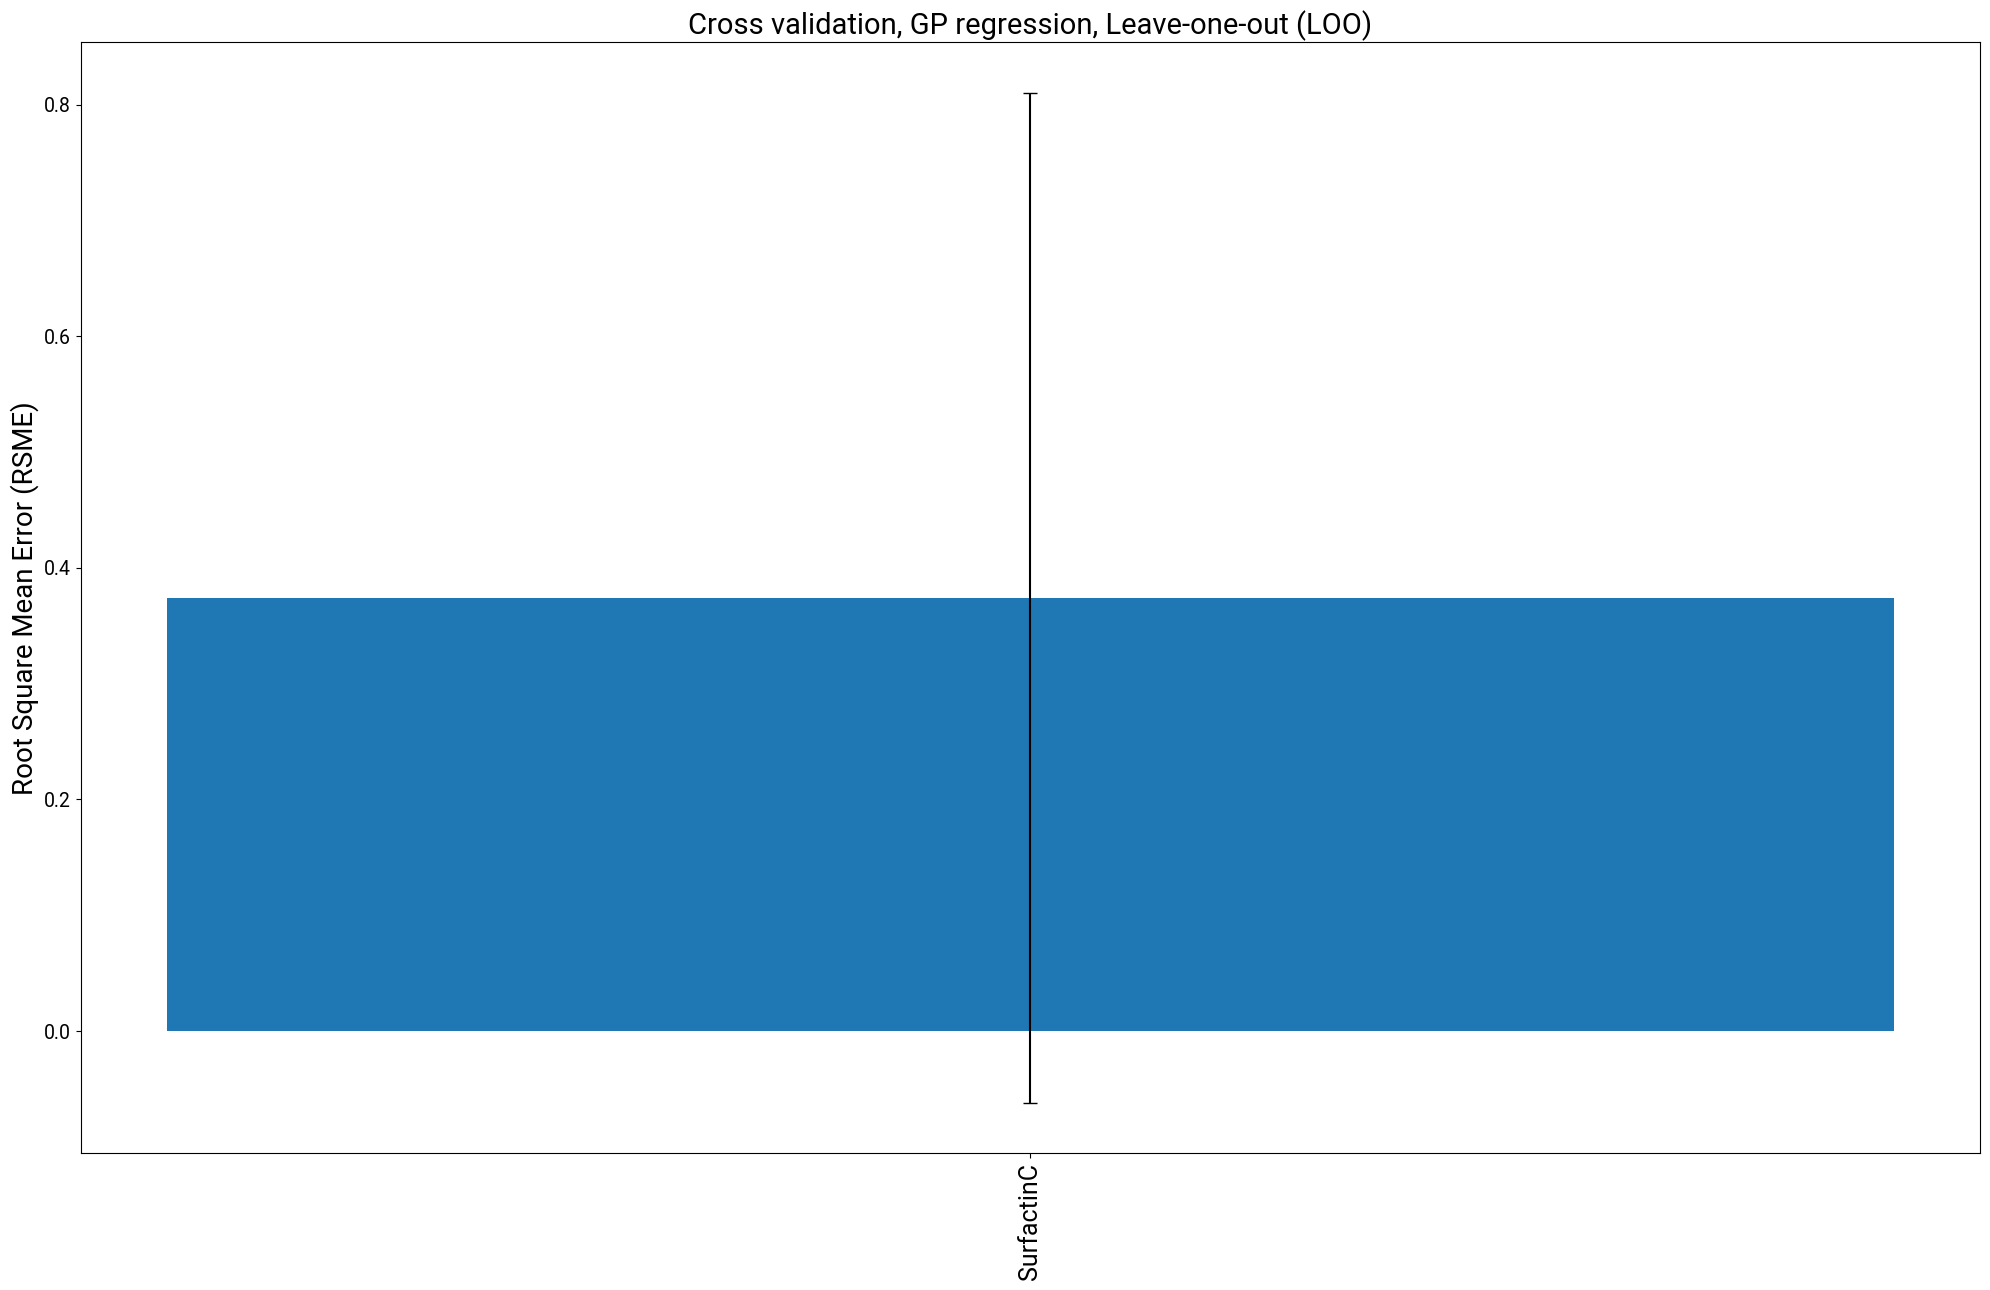

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming scorespandas is a previously defined DataFrame with your data
means = scorespandas.mean()
std_devs = scorespandas.std()

# Sorting the means and corresponding standard deviations
sorted_indices = means.sort_values().index
sorted_means = means[sorted_indices]
sorted_std_devs = std_devs[sorted_indices]

# Plotting the sorted data
plt.figure(figsize=(20, 13))
plt.bar(sorted_indices, sorted_means, yerr=sorted_std_devs, capsize=5)

# Increase font size for xticks and yticks
plt.xticks(rotation=90, fontsize=18)  # Increase fontsize for x-axis labels
plt.yticks(fontsize=14)  # Increase fontsize for y-axis labels

# Increase font size for axis labels and title
plt.ylabel('Root Square Mean Error (RSME)', fontsize=20)
plt.title('Cross validation, GP regression, Leave-one-out (LOO)', fontsize=21)

plt.tight_layout()
plt.savefig("cross_rsme_loo_nonscaled.jpg",bbox_inches="tight",dpi=400)
plt.show()



#Plot and Tukey calculations

import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt

# Assuming scorespandas is your DataFrame
# Example: scorespandas = pd.DataFrame({'Met1': [1, 2, 3], 'Met2': [2, 3, 4], 'Met3': [3, 4, 5]})

# Reshaping DataFrame for ANOVA
long_df = scorespandas.melt(var_name='Metabolite', value_name='Value')

# ANOVA
f_value, p_value = stats.f_oneway(*[group['Value'].values for name, group in long_df.groupby('Metabolite')])
print('ANOVA results: F-value = {:.2f}, p-value = {:.3f}'.format(f_value, p_value))

# Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=long_df['Value'], groups=long_df['Metabolite'], alpha=0.05)
print(tukey_results)

# Extract group labels from Tukey's test result
group_labels = tukey_results.summary().data[1:]
group_mapping = {row[0]: row[2] for row in group_labels}

# Plotting
means = scorespandas.mean()
std_devs = scorespandas.std()
sorted_indices = means.sort_values().index
sorted_means = means[sorted_indices]
sorted_std_devs = std_devs[sorted_indices]

plt.figure(figsize=(20, 10))
bars = plt.bar(sorted_indices, sorted_means, yerr=sorted_std_devs, capsize=5)

# Adding group labels above bars
for bar in bars:
    metabolite = bar.get_x() + bar.get_width()/2
    plt.text(metabolite, bar.get_height(), group_mapping[bar.get_label()],
             ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Value', fontsize=16)
plt.title('ANOVA and Tukey HSD Test Results', fontsize=18)
plt.tight_layout()
plt.show()


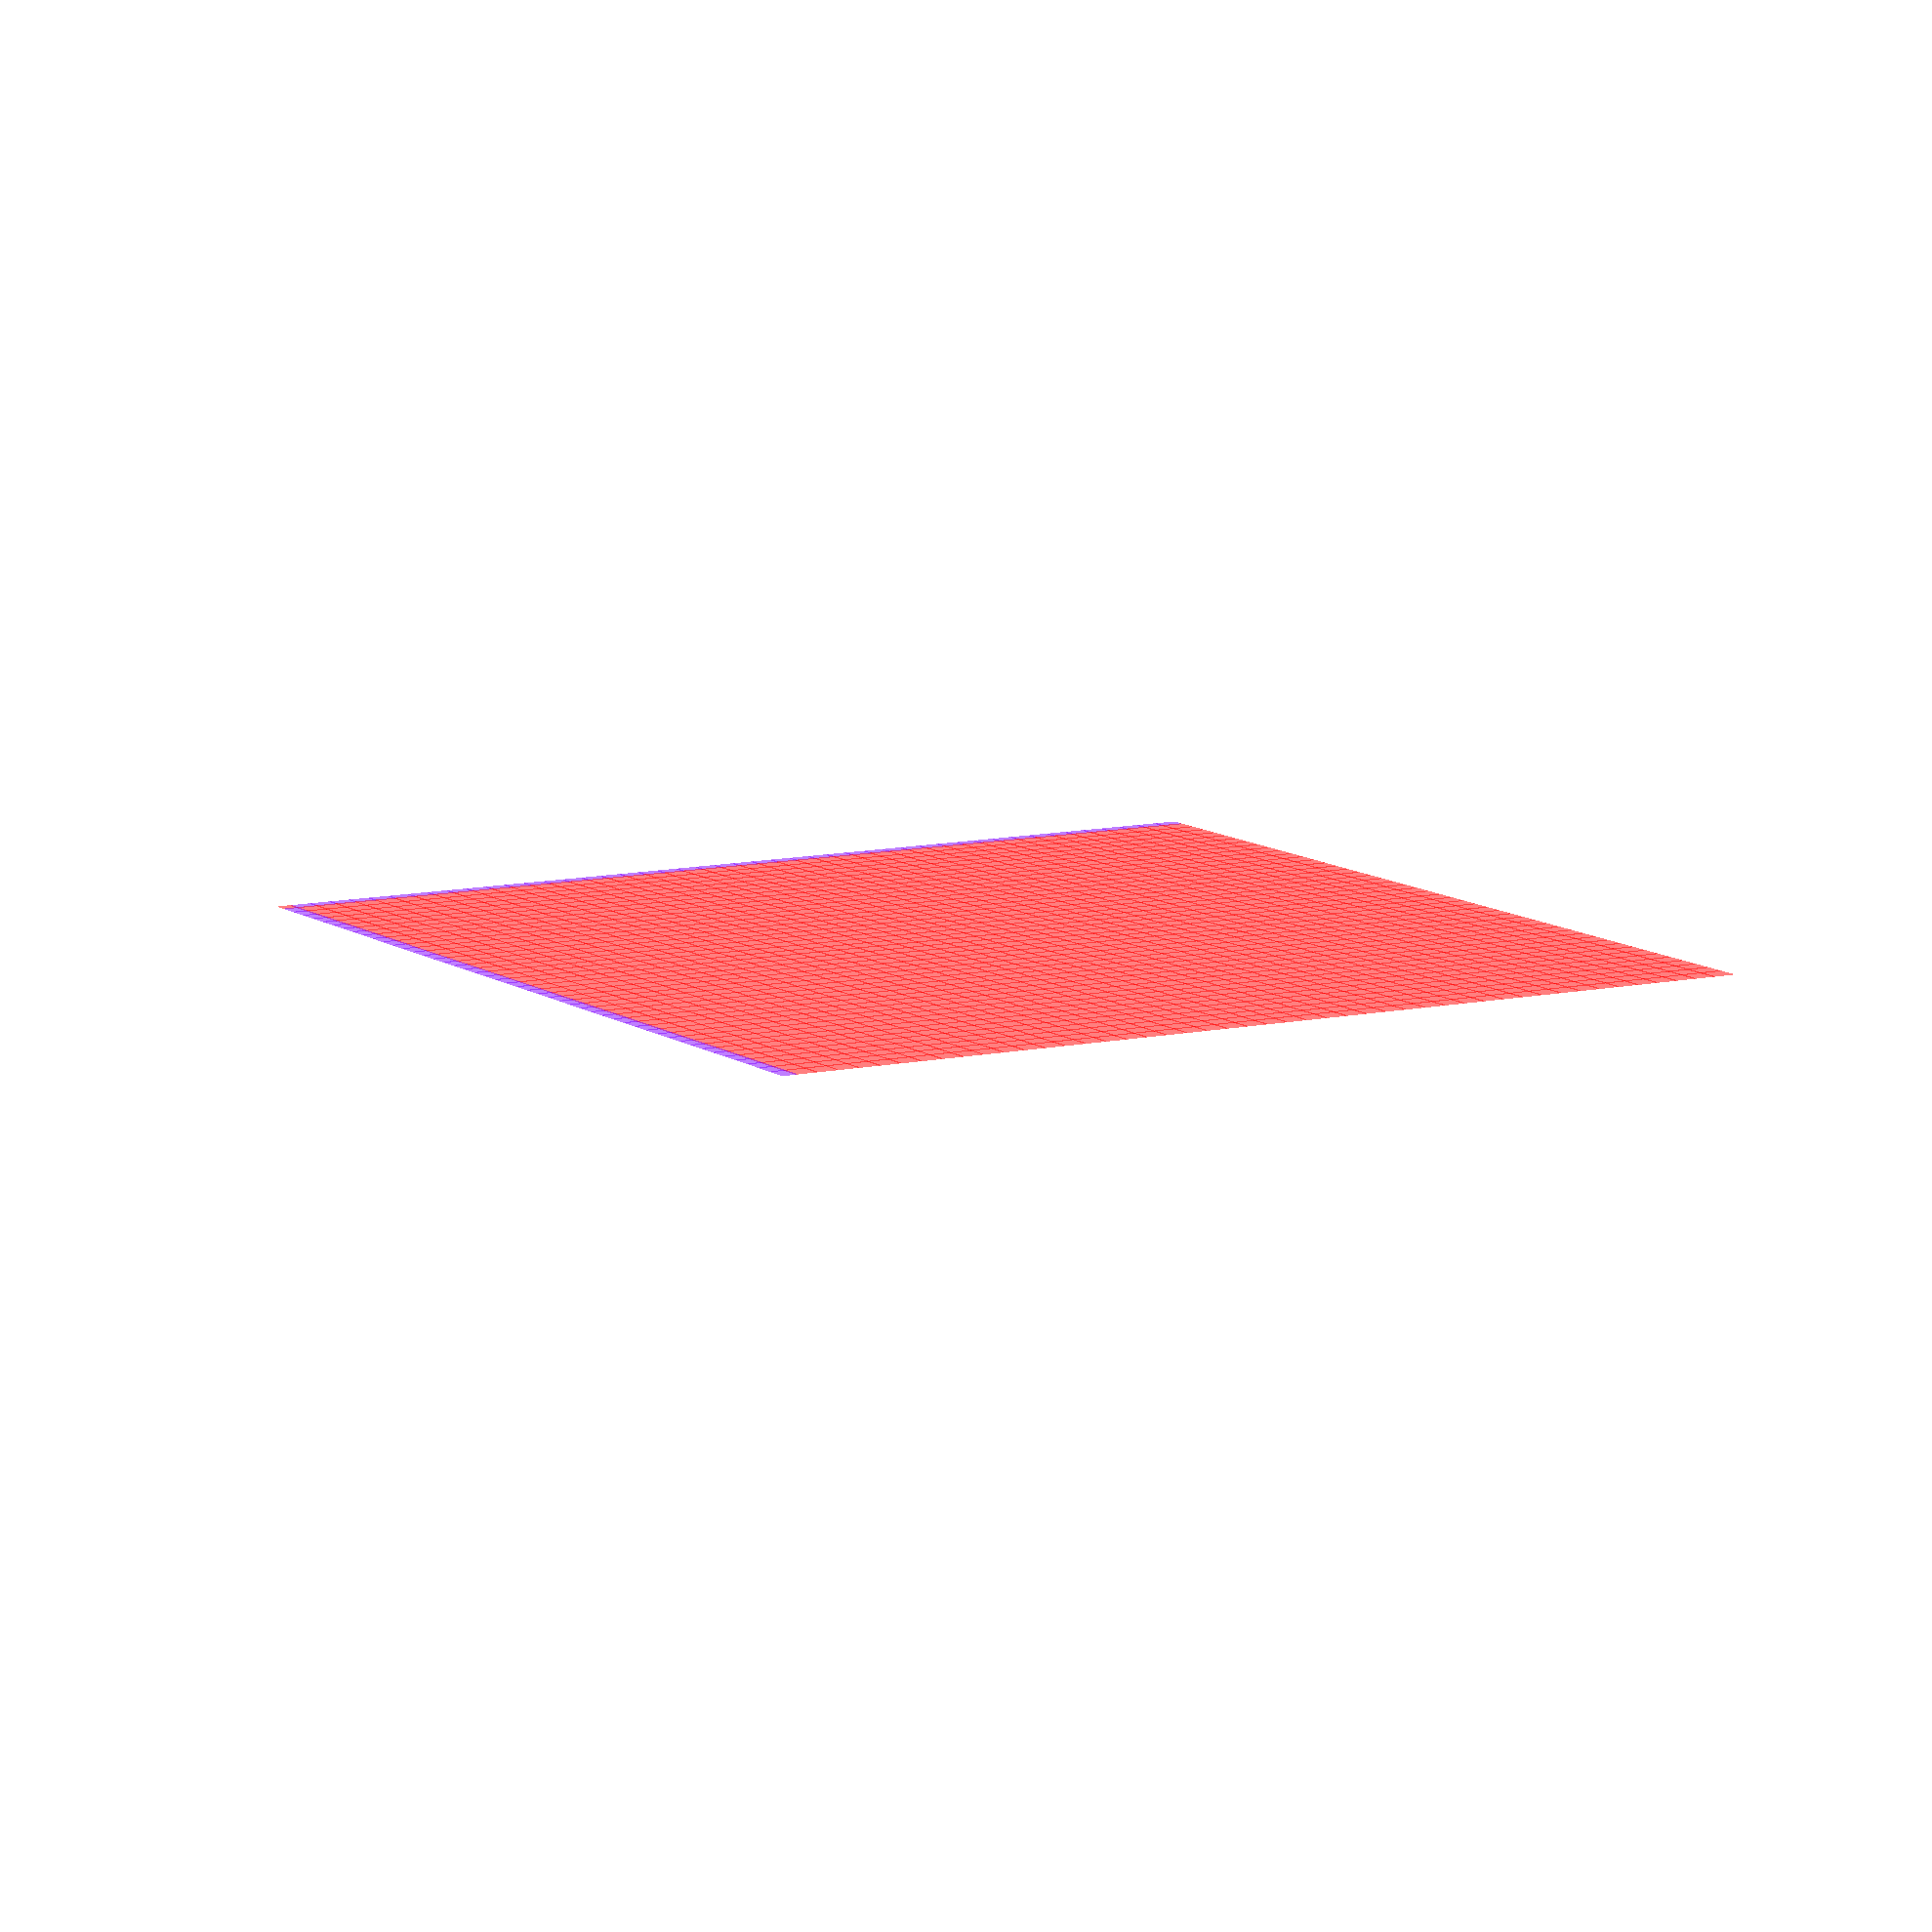

In [30]:
#plot 3 surface with the info, quite useful for diagrams, such as the one in figure 1

from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting

fig = plt.figure(figsize=(11,10),dpi=200)
ax = fig.add_subplot(111, projection='3d')

# Transform to meshgrid for 3D plotting
X = xv*6
Y = yv*240
Z = mcol2

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap="rainbow", linewidth=0, antialiased=False, alpha=0.5)

ax.view_init(elev=10., azim=150) 
# Hide axes and labels
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# Disable grid
ax.grid(False)
# Add colorbar
#fig.colorbar(surf, aspect=5)

# Remove axis lines
ax.xaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) # White, transparent
ax.yaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) # White, transparent
ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) # White, transparent

# Remove ticks
ax.set_xticks([]) 
ax.set_yticks([]) 
ax.set_zticks([])
plt.tight_layout()

#plt.savefig("surface.png", transparent=True,dpi=200,bbox_inches="tight")
plt.show()
plt.close()

/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


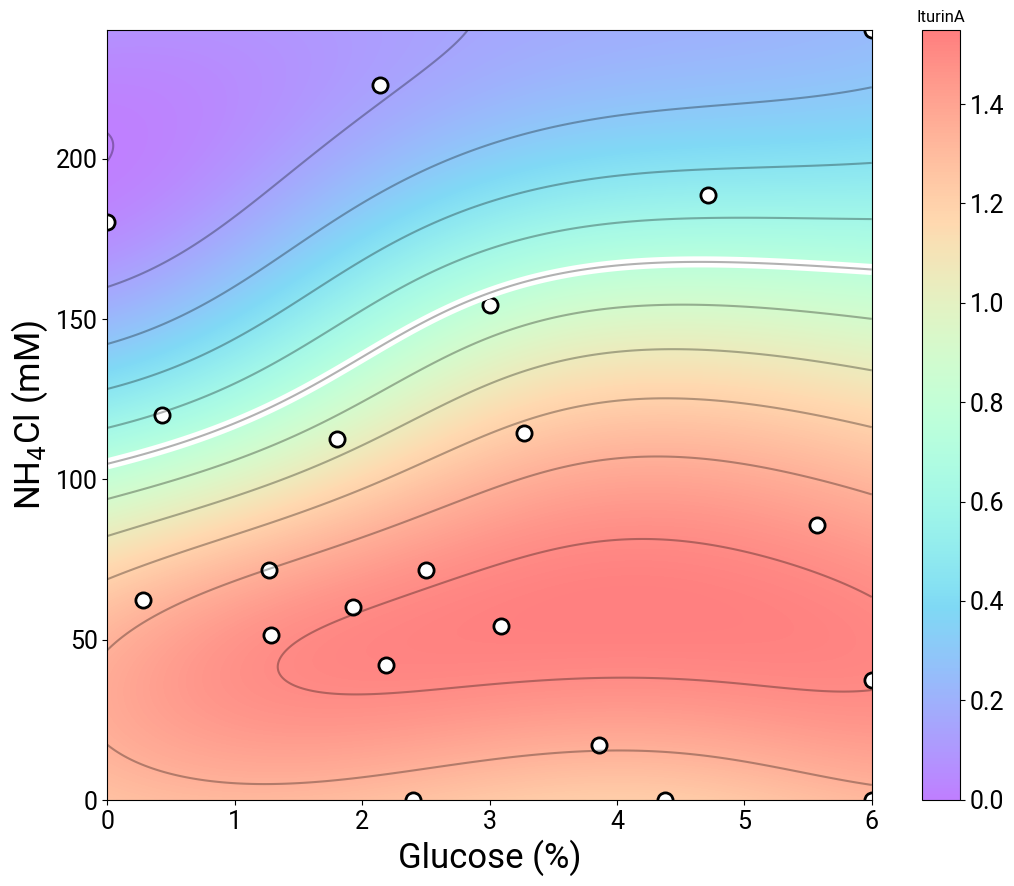

/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


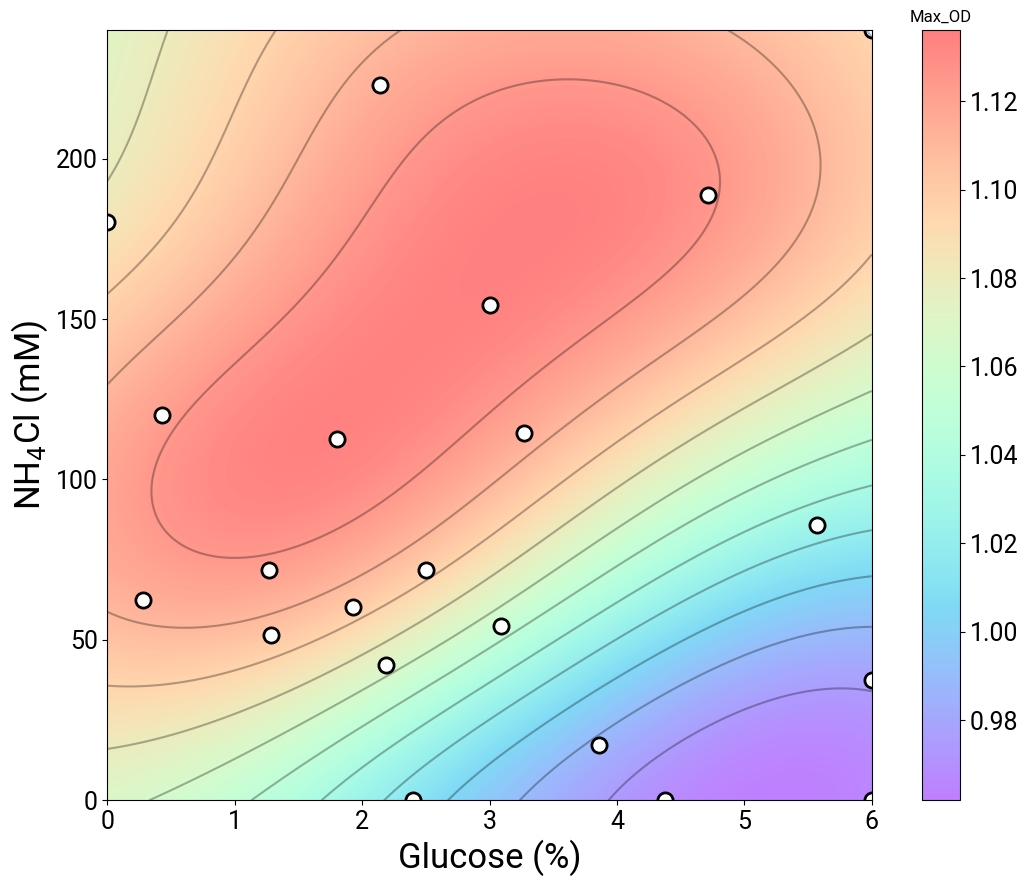

In [31]:
#save just two models/compounds for multiobjective 
#create list for additional data, extra_points are the simulated points, directional are the radial grid points
extra_points=[]
directional=[]
modellist=[]
twomol=["IturinA","Max_OD"]
for molecule in twomol: #pd.unique(master_table["molecule"])
    #selecting one molecule
    tmptable=master_table.loc[master_table["molecule"]==molecule]
    #merge molecule data with arms
    ready_table=master_itera.merge(tmptable, on="arm_name")
    #extract iteration
    ready_table["iteration"]=ready_table["arm_name"].apply(lambda x: x[0])
    #take back to normalized values
    scaler = MinMaxScaler()
    scaler.fit(ready_table[["Glucose","NH4Cl"]].values)
    #define temporary number of samples, 7 combinations multiplied by the number of iterations, 3 in this case
    samples=7*3
    #create tensors for model training
    train_x=torch.from_numpy(scaler.transform(ready_table[["Glucose","NH4Cl"]].values))
    train_y=torch.from_numpy(ready_table["mean"].values).reshape(samples,1)
    observed_var=torch.from_numpy(ready_table["sem"].values).reshape(samples,1)
    #model training
    model = HeteroskedasticSingleTaskGP(train_X=train_x, train_Y=train_y,train_Yvar=observed_var)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    #torch.save(mll.model.state_dict(), molecule+'_model_state.pth')
    #create grid of points for visualization, define number of points, 1000 is a good number
    res=1001
    X_1 = np.linspace(0, 1, res)
    X_2 = np.linspace(0, 1, res)
    #creating grid
    xv,yv=np.meshgrid(X_1,X_2)
    xsys=np.column_stack((xv.flatten(),yv.flatten()))
    xsys2=torch.from_numpy(xsys)#.to(device)
    #making prediction, mcol is the mean, scol is the variance
    with torch.no_grad():
        #posterior = model.posterior(xsys2)
        predictive_posterior = mll.model.posterior(xsys2, observation_noise=True)
        mcol=predictive_posterior.mean
        scol=predictive_posterior.variance
        mcol2=mcol.reshape(res, -1).cpu().numpy()
        scol2=scol.reshape(res, -1).cpu().numpy()
    
        
    '''
    res_sm=21
    X_1_sm = np.linspace(0, 1, res_sm)
    X_2_sm = np.linspace(0, 1, res_sm)
    xv_sm,yv_sm=np.meshgrid(X_1_sm,X_2_sm)
    xsys_sm=np.column_stack((xv_sm.flatten(),yv_sm.flatten()))
    xsys2_sm=torch.from_numpy(xsys_sm)#.to(device)
    with torch.no_grad():
        #posterior = model.posterior(xsys2)
        predictive_posterior_sm = mll.model.posterior(xsys2_sm, observation_noise=True)
        mcol_sm=predictive_posterior_sm.mean
        scol_sm=predictive_posterior_sm.variance
        mcol2_sm=mcol_sm.reshape(res_sm, -1).cpu().numpy()
        scol2_sm=scol_sm.reshape(res_sm, -1).cpu().numpy()
    '''
    #radial grids for directional information
    for coord in dirpoints:
        res_sm=100
        X_1_sm = np.linspace(0.133, coord[1], res_sm)
        X_2_sm = np.linspace(0.208, coord[2], res_sm)
        #xv_sm,yv_sm=np.meshgrid(X_1_sm,X_2_sm)
        xsys_sm=np.column_stack((X_1_sm,X_2_sm))
        xsys2_sm=torch.from_numpy(xsys_sm)#.to(device)
        with torch.no_grad():
            #posterior = model.posterior(xsys2)
            predictive_posterior_sm = mll.model.posterior(xsys2_sm, observation_noise=True)
            mcol_sm=predictive_posterior_sm.mean
            scol_sm=predictive_posterior_sm.variance
            mcol2_sm=mcol_sm.reshape(res_sm, -1).cpu().numpy()
            scol2_sm=scol_sm.reshape(res_sm, -1).cpu().numpy()
        valdi=pd.DataFrame({"Glucose":(xsys2_sm.cpu().numpy())[:,0],"NH4Cl":(xsys2_sm.cpu().numpy())[:,1],molecule:mcol_sm.cpu().numpy().reshape(res_sm,)})
        directional.append([coord,valdi])  
   
    #dx, dy = np.gradient(mcol2_sm)
    #start plotting
    fig, ax = plt.subplots(figsize=(11,10))
    
    #making grid and mean predicted values as dataframe
    points=pd.DataFrame({"Glucose":(xsys2.cpu().numpy())[:,0],"NH4Cl":(xsys2.cpu().numpy())[:,1],molecule:mcol.cpu().numpy().reshape(res*res,)})
    extra_points.append(points)
    #valdi=pd.DataFrame({"Glucose":(xsys2_sm.cpu().numpy())[:,0],"NH4Cl":(xsys2_sm.cpu().numpy())[:,1],molecule:mcol_sm.cpu().numpy().reshape(res_sm,)})
    #directional.append(valdi)
    
    #generate level curves
    contours=ax.contour(xv*6,yv*240, mcol2,levels=[0.75],colors='white', linewidths=8)#, label='Noise-free objective')
    contours2=ax.contour(xv*6,yv*240, mcol2,11,colors='black',alpha=0.3)
    #contours3=ax.contour(xv*6,yv*240, mcol2,levels=[1.7],colors='black',alpha=0.3)
    #ax.clabel(contours,inline=True,fontsize=11)
    #label_point_2(ready_table["Glucose"],ready_table["NH4Cl"] ,ready_table["arm_name"].apply(lambda x: x[-1]), ax)
    im=ax.imshow(mcol2,extent=[0,6,0,240],origin='lower',cmap="rainbow",alpha=0.5,aspect='auto') #PRGnrainbow[0,6,0,240]#rainbow
    #dfdx, dfdy = grad_f(xv, yv)
    #qui=ax.quiver(xv_sm*6, yv_sm*240, dx, dy)
    m = ['o', 'x',"^"]

    for i in range(0,3):
        tempo=ready_table.loc[ready_table["iteration"]==str(i)].copy()
        if m[i]!="x":
            ax.scatter("Glucose","NH4Cl",marker="o",s=120,data=tempo,facecolors='white', edgecolors='black',linewidths=2,label="I"+str(i))
        else:
            ax.scatter("Glucose","NH4Cl",marker="o",s=120,data=tempo,facecolors='white', edgecolors='black',linewidths=2,label="I"+str(i)) #marker=m[i]#c="black"

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.5)
    cb=fig.colorbar(im, cax=cax)
    cb.ax.tick_params(labelsize=18)


    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.tick_params(axis='both', which='minor', labelsize=18)

    ax.set_xlabel("Glucose (%)",fontsize=25)
    ax.set_ylabel(r"NH$_{4}$Cl (mM)",fontsize=25)

    #ax.legend(loc=1, prop={'size': 15})
    plt.title(molecule)#"s.e.m"
    plt.show()
    #plt.savefig(molecule+"_surface_paper.jpg",bbox_inches="tight",dpi=400)
    plt.close()
    modellist.append(mll.model)
    del model

In [32]:
#sampling fine grid for pareto plots
#model=ModelListGP(*modellist)
res=100*100
#regular
#X_1 = np.linspace(0, 1, res)
#X_2 = np.linspace(0, 1, res)

privi=np.random.rand(res,2)
X_1= privi[:,0]
X_2= privi[:,1]
#creating grid
#xv,yv=np.meshgrid(X_1,X_2)
#xsys=np.column_stack((xv.flatten(),yv.flatten()))
xsys2=torch.from_numpy(privi)#.to(device)
#making prediction, mcol is the mean, scol is the variance
with torch.no_grad():
    #posterior = model.posterior(xsys2)
    predictive_posterior_0 = modellist[0].posterior(xsys2, observation_noise=True)
    mcol_0=predictive_posterior_0.mean
    scol_0=predictive_posterior_0.variance
    mcol2_0=mcol_0.reshape(res, -1).cpu().numpy()
    scol2_0=scol_0.reshape(res, -1).cpu().numpy()
    predictive_posterior_1 = modellist[1].posterior(xsys2, observation_noise=True)
    mcol_1=predictive_posterior_1.mean
    scol_1=predictive_posterior_1.variance
    mcol2_1=mcol_1.reshape(res, -1).cpu().numpy()
    scol2_1=scol_1.reshape(res, -1).cpu().numpy()

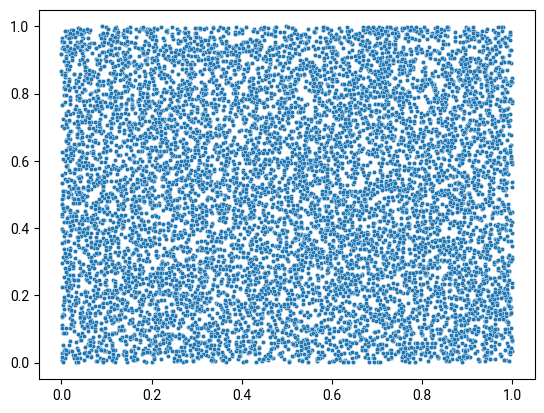

In [33]:
#saving a picture of the sample
sns.scatterplot(x=privi[:,0],y=privi[:,1],s=10)
plt.show()
#plt.savefig("SurfactinC_random_sample_100_100.jpg",bbox_inches="tight",dpi=2000)

Text(37.847222222222214, 0.5, 'Iturin A')

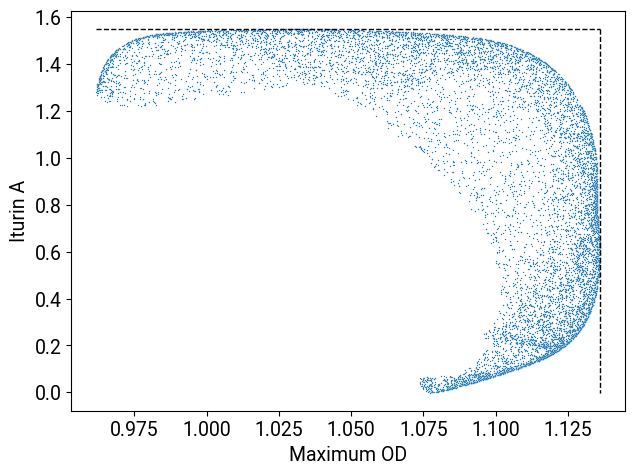

In [34]:
gridi=pd.DataFrame({twomol[0]:mcol_0.cpu().numpy().T[0],twomol[1]:mcol_1.cpu().numpy().T[0]})

sns.scatterplot(data=gridi, x=twomol[1], y=twomol[0], s=1)

min_value_x = min(gridi[twomol[1]])
max_value_x = max(gridi[twomol[1]])
min_value_y = min(gridi[twomol[0]])
max_value_y = max(gridi[twomol[0]])

plt.plot([min_value_x, max_value_x], [max_value_y, max_value_y], 'k--',linewidth=1)  # horizontal dashed line
plt.plot([max_value_x, max_value_x], [max_value_y, min_value_y], 'k--',linewidth=1)  # vertical dashed line

plt.tick_params(axis='both', which='major', labelsize=14)  # adjust this to your preference

plt.tight_layout()
plt.xlabel("Maximum OD", fontsize=14)  # adjust this to your preference
plt.ylabel(twomol[0][0:-1]+" "+twomol[0][-1], fontsize=14)  # adjust this to your preference

#plt.savefig(twomol[0]+"_multi_random_100.png", transparent=True, bbox_inches="tight", dpi=1000)

In [35]:
#-----------------------------------------------------------

In [36]:
from sklearn.metrics import r2_score

In [46]:
#create list for additional data, extra_points are the simulated points, directional are the radial grid points
#isolate data for a single compound/feature but for many iterations
extra_points=[]
directional=[]
modellist=[]
meanlist=[]
stdlist=[]
avermse=[]
stdrmse=[]
r2list=[]
for molecule in ["SurfactinC"]: #pd.unique(master_table["molecule"])
    #selecting one molecule
    tmptable=master_table.loc[master_table["molecule"]==molecule]
    #print(tmptable)
    
    #merge molecule data with arms
    ready_table=master_itera.merge(tmptable, on="arm_name")
    
    #extract iteration
    ready_table["iteration"]=ready_table["arm_name"].apply(lambda x: x[0])
    #print(ready_table)
    #ready_table=ready_table.drop(1)
    #take back to normalized values
    #print(ready_table)
    ready_table_2=ready_table.copy()
    for lab in pd.unique(ready_table_2["iteration"]):
        ready_table=ready_table_2.loc[ready_table_2["iteration"].apply(int)<=int(lab)].copy()
        print(ready_table)
        scaler = MinMaxScaler()
        scaler.fit(ready_table[["Glucose","NH4Cl"]].values)
        #define temporary number of samples, 7 combinations multiplied by the number of iterations, 3 in this case
        samples=7*(int(lab)+1) #6
        #create tensors for model training
        train_x=torch.from_numpy(scaler.transform(ready_table[["Glucose","NH4Cl"]].values))
        train_y=torch.from_numpy(ready_table["mean"].values).reshape(samples,1)
        observed_var=torch.from_numpy(ready_table["sem"].values).reshape(samples,1)
        #model training
        model = HeteroskedasticSingleTaskGP(train_X=train_x, train_Y=train_y,train_Yvar=observed_var)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)
        #torch.save(mll.model.state_dict(), molecule+'_model_state.pth')
        #create grid of points for visualization, define number of points, 1000 is a good number
        res=1001
        X_1 = np.linspace(0, 1, res)
        X_2 = np.linspace(0, 1, res)
        #creating grid
        xv,yv=np.meshgrid(X_1,X_2)
        xsys=np.column_stack((xv.flatten(),yv.flatten()))
        xsys2=torch.from_numpy(xsys)#.to(device)
        #making prediction, mcol is the mean, scol is the variance
        with torch.no_grad():
            #posterior = model.posterior(xsys2)
            predictive_posterior = mll.model.posterior(xsys2, observation_noise=True)
            mcol=predictive_posterior.mean
            scol=predictive_posterior.variance
            mcol2=mcol.reshape(res, -1).cpu().numpy()
            scol2=scol.reshape(res, -1).cpu().numpy()
        print(lab)
        analysis_0=ready_table.loc[ready_table["iteration"].isin([str(i) for i in range(0, int(lab)+1)])]
        res0=analysis_0.shape[0]
        xsys0=torch.from_numpy(scaler.transform(analysis_0[["Glucose","NH4Cl"]].copy().values))
        with torch.no_grad():
            predictive_posterior_0 = mll.model.posterior(xsys0, observation_noise=True)
            mcol_0=predictive_posterior_0.mean
            scol_0=predictive_posterior_0.variance
            mcol2_0=mcol_0.reshape(res0).cpu().numpy()
            scol2_0=scol_0.reshape(res0).cpu().numpy()
            acti=analysis_0["mean"].values
            r2list.append(r2_score(acti,mcol2_0))    
           # Assuming ready_table is a pandas DataFrame
        samples = len(ready_table)
        kf = KFold(n_splits=samples, shuffle=True, random_state=42)
    
        # Placeholder for RMSE scores
        rmse_scores = []
    
        for train_index, test_index in kf.split(ready_table):
            # Splitting the data
            train, test = ready_table.iloc[train_index], ready_table.iloc[test_index]
        
            # Feature scaling
            train_x = torch.from_numpy(scaler.transform(train[["Glucose", "NH4Cl"]].values))
            test_x = torch.from_numpy(scaler.transform(test[["Glucose", "NH4Cl"]].values))
        
            # Preparing target variables
            train_y = torch.from_numpy(train["mean"].values).reshape(-1, 1)
            test_y = test["mean"].values
        
            # Preparing observed variance
            observed_var = torch.from_numpy(train["sem"].values).reshape(-1, 1)
        
            # Model training
            model = HeteroskedasticSingleTaskGP(train_X=train_x, train_Y=train_y, train_Yvar=observed_var)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            fit_gpytorch_mll(mll)
        
            with torch.no_grad():
                predictive_posterior = mll.model.posterior(test_x, observation_noise=True)
                predictions = predictive_posterior.mean
                pre2=predictions.reshape(1,-1).cpu().numpy()
                rsme = np.sqrt(np.mean((pre2[0] - test_y) ** 2))
                #print(rsme)
            # Store the RMSE score
            rmse_scores.append(rsme.item())
    
        # Average RMSE across all folds
        #print(rmse_scores)
        average_rmse = np.mean(rmse_scores)
        std_rmse = np.std(rmse_scores)
        avermse.append(average_rmse)
        stdrmse.append(std_rmse)
        #print("Average RMSE: ", average_rmse)
        #print("Std RMSE: ", std_rmse)


        '''
        res_sm=21
        X_1_sm = np.linspace(0, 1, res_sm)
        X_2_sm = np.linspace(0, 1, res_sm)
        xv_sm,yv_sm=np.meshgrid(X_1_sm,X_2_sm)
        xsys_sm=np.column_stack((xv_sm.flatten(),yv_sm.flatten()))
        xsys2_sm=torch.from_numpy(xsys_sm)#.to(device)
        with torch.no_grad():
            #posterior = model.posterior(xsys2)
            predictive_posterior_sm = mll.model.posterior(xsys2_sm, observation_noise=True)
            mcol_sm=predictive_posterior_sm.mean
            scol_sm=predictive_posterior_sm.variance
            mcol2_sm=mcol_sm.reshape(res_sm, -1).cpu().numpy()
            scol2_sm=scol_sm.reshape(res_sm, -1).cpu().numpy()
        '''
        #radial grids for directional information
        for coord in dirpoints:
            res_sm=100
            X_1_sm = np.linspace(0.133, coord[1], res_sm)
            X_2_sm = np.linspace(0.208, coord[2], res_sm)
            #xv_sm,yv_sm=np.meshgrid(X_1_sm,X_2_sm)
            xsys_sm=np.column_stack((X_1_sm,X_2_sm))
            xsys2_sm=torch.from_numpy(xsys_sm)#.to(device)
            with torch.no_grad():
                #posterior = model.posterior(xsys2)
                predictive_posterior_sm = mll.model.posterior(xsys2_sm, observation_noise=True)
                mcol_sm=predictive_posterior_sm.mean
                scol_sm=predictive_posterior_sm.variance
                mcol2_sm=mcol_sm.reshape(res_sm, -1).cpu().numpy()[0]
                scol2_sm=scol_sm.reshape(res_sm, -1).cpu().numpy()[0]
            valdi=pd.DataFrame({"Glucose":(xsys2_sm.cpu().numpy())[:,0],"NH4Cl":(xsys2_sm.cpu().numpy())[:,1],molecule:mcol_sm.cpu().numpy().reshape(res_sm,)})
            directional.append([coord,valdi])  

        #dx, dy = np.gradient(mcol2_sm)
        #start plotting
        fig, ax = plt.subplots(figsize=(11,10))

        #making grid and mean predicted values as dataframe
        points=pd.DataFrame({"Glucose":(xsys2.cpu().numpy())[:,0],"NH4Cl":(xsys2.cpu().numpy())[:,1],molecule:mcol.cpu().numpy().reshape(res*res,)})
        extra_points.append(points)
        #valdi=pd.DataFrame({"Glucose":(xsys2_sm.cpu().numpy())[:,0],"NH4Cl":(xsys2_sm.cpu().numpy())[:,1],molecule:mcol_sm.cpu().numpy().reshape(res_sm,)})
        #directional.append(valdi)

        #generate level curves
        contours=ax.contour(xv*6,yv*240, mcol2,levels=[0.75],colors='white', linewidths=8)#, label='Noise-free objective')
        contours2=ax.contour(xv*6,yv*240, mcol2,11,colors='black',alpha=0.3)
        #contours3=ax.contour(xv*6,yv*240, mcol2,levels=[1.7],colors='black',alpha=0.3)
        #ax.clabel(contours,inline=True,fontsize=11)
        #label_point_2(ready_table["Glucose"],ready_table["NH4Cl"] ,ready_table["arm_name"].apply(lambda x: x[-1]), ax)
        im=ax.imshow(mcol2,extent=[0,6,0,240],origin='lower',cmap="rainbow",alpha=0.5,aspect='auto') #PRGnrainbow[0,6,0,240]#rainbow
        #dfdx, dfdy = grad_f(xv, yv)
        #qui=ax.quiver(xv_sm*6, yv_sm*240, dx, dy)
        m = ['o', 'x',"^"]

        for i in range(0,3):
            tempo=ready_table.loc[ready_table["iteration"]==str(i)].copy()
            if m[i]!="x":
                ax.scatter("Glucose","NH4Cl",marker="o",s=120,data=tempo,facecolors='white', edgecolors='black',linewidths=2,label="I"+str(i))
            else:
                ax.scatter("Glucose","NH4Cl",marker="o",s=120,data=tempo,facecolors='white', edgecolors='black',linewidths=2,label="I"+str(i)) #marker=m[i]#c="black"

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.5)
        cb=fig.colorbar(im, cax=cax)
        cb.ax.tick_params(labelsize=24)
        #cb.set_label(molecule, fontsize=22)


        ax.tick_params(axis='both', which='major', labelsize=24)
        ax.tick_params(axis='both', which='minor', labelsize=24)

        ax.set_xlabel("Glucose (%)",fontsize=32)
        ax.set_ylabel(r"NH$_{4}$Cl (mM)",fontsize=32)

        #ax.legend(loc=1, prop={'size': 15})
        plt.title(molecule, fontsize=24)#"s.e.m"
        #plt.show()
        print(lab)
        if lab=="2":
            plt.savefig(molecule+"_surface_paper.jpg",bbox_inches="tight",dpi=600)
        plt.close()
        modellist.append(mll.model)
        meanlist.append(mcol2_0)
        stdlist.append(scol2_0)
        del model

  arm_name   Glucose       NH4Cl    molecule      mean       sem iteration
0      0_1  0.428571  120.000000  SurfactinC  1.004578  0.293978         0
1      0_2  1.285714   51.428571  SurfactinC  2.629998  0.216202         0
2      0_3  2.142857  222.857143  SurfactinC  0.259690  0.099338         0
3      0_4  3.000000  154.285714  SurfactinC  1.586320  0.322037         0
4      0_5  3.857143   17.142857  SurfactinC  1.648880  0.322248         0
5      0_6  4.714286  188.571429  SurfactinC  0.630444  0.073187         0
6      0_7  5.571429   85.714286  SurfactinC  1.324136  0.134904         0


/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


0


/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please co

0
   arm_name   Glucose       NH4Cl    molecule      mean       sem iteration
0       0_1  0.428571  120.000000  SurfactinC  1.004578  0.293978         0
1       0_2  1.285714   51.428571  SurfactinC  2.629998  0.216202         0
2       0_3  2.142857  222.857143  SurfactinC  0.259690  0.099338         0
3       0_4  3.000000  154.285714  SurfactinC  1.586320  0.322037         0
4       0_5  3.857143   17.142857  SurfactinC  1.648880  0.322248         0
5       0_6  4.714286  188.571429  SurfactinC  0.630444  0.073187         0
6       0_7  5.571429   85.714286  SurfactinC  1.324136  0.134904         0
7       1_1  0.276490   62.564451  SurfactinC  1.744168  0.190712         1
8       1_2  1.271239   71.691165  SurfactinC  1.279926  0.230891         1
9       1_3  1.931069   60.141897  SurfactinC  1.219375  0.096258         1
10      1_4  2.187244   42.202748  SurfactinC  1.385525  0.127937         1
11      1_5  2.503625   71.863152  SurfactinC  1.481231  0.259969         1
12      1_

/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


1


/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please co

1
   arm_name   Glucose       NH4Cl    molecule      mean       sem iteration
0       0_1  0.428571  120.000000  SurfactinC  1.004578  0.293978         0
1       0_2  1.285714   51.428571  SurfactinC  2.629998  0.216202         0
2       0_3  2.142857  222.857143  SurfactinC  0.259690  0.099338         0
3       0_4  3.000000  154.285714  SurfactinC  1.586320  0.322037         0
4       0_5  3.857143   17.142857  SurfactinC  1.648880  0.322248         0
5       0_6  4.714286  188.571429  SurfactinC  0.630444  0.073187         0
6       0_7  5.571429   85.714286  SurfactinC  1.324136  0.134904         0
7       1_1  0.276490   62.564451  SurfactinC  1.744168  0.190712         1
8       1_2  1.271239   71.691165  SurfactinC  1.279926  0.230891         1
9       1_3  1.931069   60.141897  SurfactinC  1.219375  0.096258         1
10      1_4  2.187244   42.202748  SurfactinC  1.385525  0.127937         1
11      1_5  2.503625   71.863152  SurfactinC  1.481231  0.259969         1
12      1_

/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


2


/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please co

2


In [40]:
#minimodels per iterationm

In [47]:
modellist

[HeteroskedasticSingleTaskGP(
   (likelihood): _GaussianLikelihoodBase(
     (noise_covar): HeteroskedasticNoise(
       (noise_model): SingleTaskGP(
         (likelihood): GaussianLikelihood(
           (noise_covar): HomoskedasticNoise(
             (noise_prior): SmoothedBoxPrior()
             (raw_noise_constraint): GreaterThan(1.000E-04)
           )
         )
         (mean_module): ConstantMean()
         (covar_module): ScaleKernel(
           (base_kernel): MaternKernel(
             (lengthscale_prior): GammaPrior()
             (raw_lengthscale_constraint): Positive()
           )
           (outputscale_prior): GammaPrior()
           (raw_outputscale_constraint): Positive()
         )
         (outcome_transform): Log()
       )
       (_noise_constraint): GreaterThan(1.000E-04)
     )
   )
   (mean_module): ConstantMean()
   (covar_module): ScaleKernel(
     (base_kernel): MaternKernel(
       (lengthscale_prior): GammaPrior()
       (raw_lengthscale_constraint): Positi

In [45]:
r2list

[0.9217547070764717, 0.5861935266951552, 0.6070416432184254]

In [46]:
meanactuallist=[]
stdactuallist=[]
for i in range(0,3):
    simpi=ready_table.loc[ready_table["iteration"].isin([str(j) for j in range(0, int(i)+1)])]
    meanactuallist.append(simpi["mean"].values)
    stdactuallist.append(simpi["sem"].values)

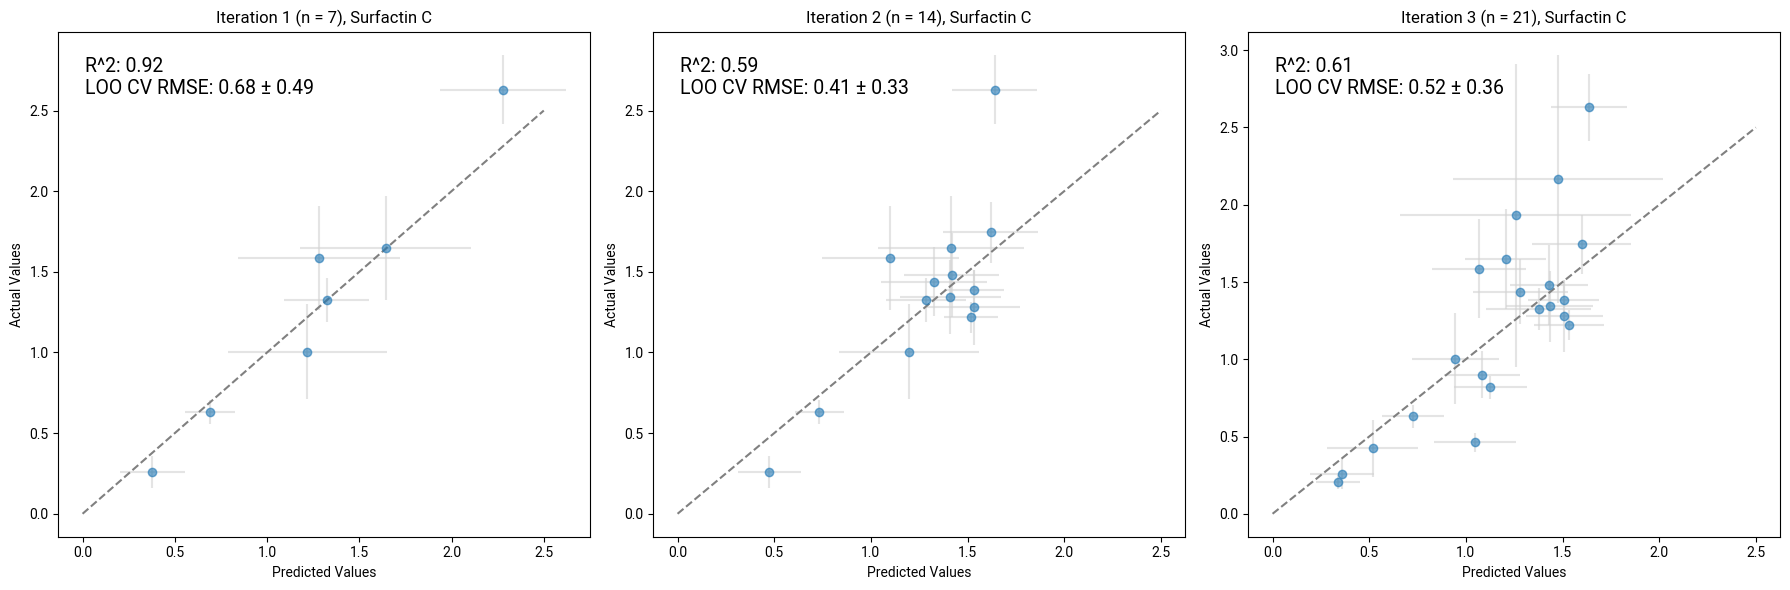

In [162]:
import numpy as np
import matplotlib.pyplot as plt

# Example data generation
np.random.seed(0)  # For reproducibility

# Sizes for each set
sizes = [7, 14, 21]

r_squared = r2list  # Example R^2 values
loocv_rmse = avermse    # Example LOOCV RMSE values
loocv_std = stdrmse     # Example LOOCV STD value

# Generating mean predictions, SEM of model predictions, mean actual values, and SEM of actual values
mean_predictions = meanlist
sem_predictions = stdlist
mean_actuals = meanactuallist 
sem_actuals = stdactuallist



# Plotting
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
ideal_line = np.linspace(0, 2.5, 100)  # Ideal case line

for i, ax in enumerate(axes):
    # Scatter plot with error bars
    ax.errorbar(mean_predictions[i], mean_actuals[i], 
                xerr=sem_predictions[i], yerr=sem_actuals[i], 
                fmt='o', ecolor='lightgray', alpha=0.6, label='Data points with SEM')
    
    # Ideal case line
    ax.plot(ideal_line, ideal_line, '--', color='gray', label='Ideal case')
    
    # Annotations for R-squared and cross-validation

    loocv_text = f'LOO CV RMSE: {loocv_rmse[i]:.2f} ± {loocv_std[i]:.2f}'
    ax.annotate(f'R^2: {r_squared[i]:.2f}\n{loocv_text}', 
                xy=(0.05, 0.95), xycoords='axes fraction', 
                verticalalignment='top', horizontalalignment='left',fontsize=14)
    
    ax.set_title(f'Iteration {i+1} (n = {sizes[i]}), Surfactin C')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values')
    #ax.legend()

plt.tight_layout()
plt.show()


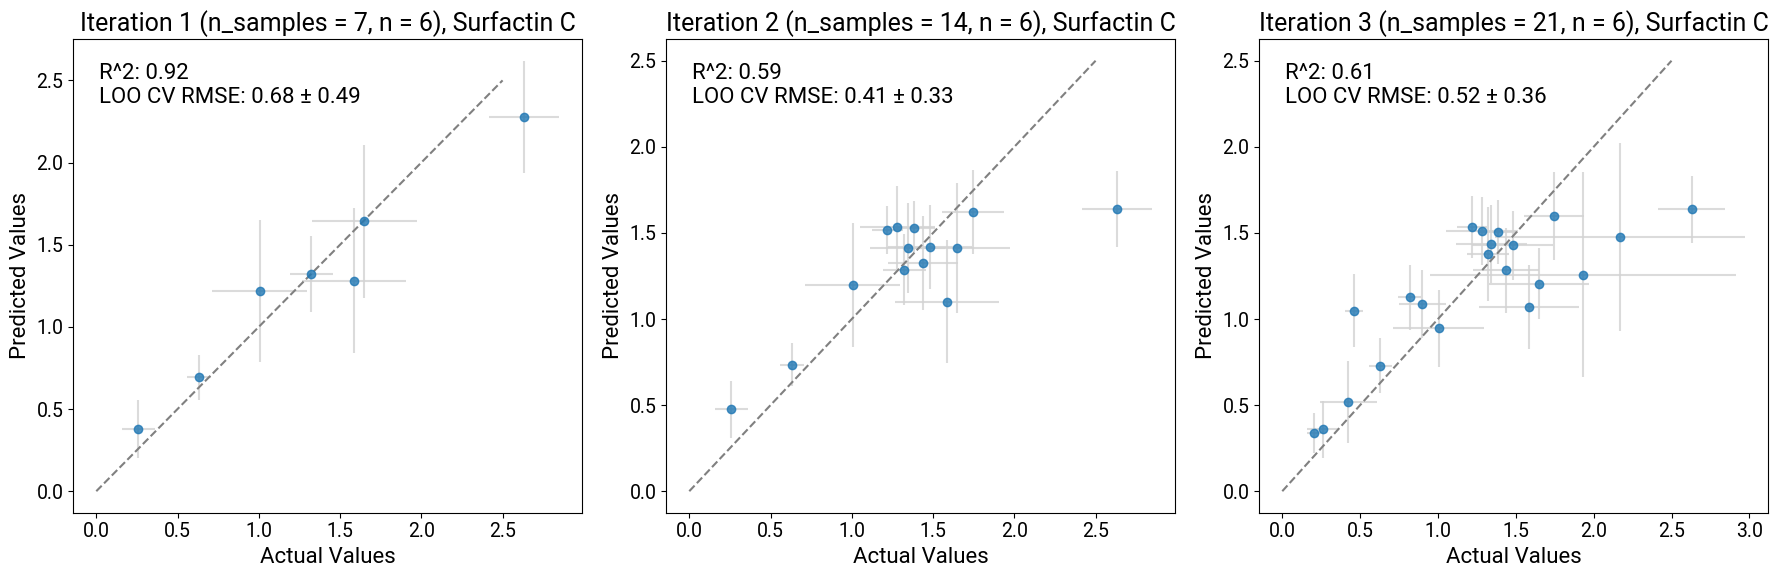

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Example data generation
np.random.seed(0)  # For reproducibility

# Sizes for each set
sizes = [7, 14, 21]

r_squared = r2list  # Example R^2 values
loocv_rmse = avermse    # Example LOOCV RMSE values
loocv_std = stdrmse     # Example LOOCV STD values

# Generating mean predictions, SEM of model predictions, mean actual values, and SEM of actual values
mean_predictions = meanlist
sem_predictions = stdlist
mean_actuals = meanactuallist 
sem_actuals = stdactuallist

# Global font size adjustment
plt.rcParams.update({'font.size': 14})  # Adjust this value as needed

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
ideal_line = np.linspace(0, 2.5, 100)  # Ideal case line

for i, ax in enumerate(axes):
    # Scatter plot with error bars, swapping x and y values, along with their errors
    ax.errorbar(mean_actuals[i], mean_predictions[i], 
                xerr=sem_actuals[i], yerr=sem_predictions[i], 
                fmt='o', ecolor='lightgray', alpha=0.8, label='Data points with SEM')
    
    # Ideal case line
    ax.plot(ideal_line, ideal_line, '--', color='gray', label='Ideal case')
    
    # Annotations for R-squared and cross-validation
    loocv_text = f'LOO CV RMSE: {loocv_rmse[i]:.2f} ± {loocv_std[i]:.2f}'
    ax.annotate(f'R^2: {r_squared[i]:.2f}\n{loocv_text}', 
                xy=(0.05, 0.95), xycoords='axes fraction', 
                verticalalignment='top', horizontalalignment='left', fontsize=16)
    
    ax.set_title(f'Iteration {i+1} (n_samples = {sizes[i]}, n = 6), Surfactin C', fontsize=18)
    ax.set_ylabel('Predicted Values', fontsize=16)  # Swapped labels for y axis
    ax.set_xlabel('Actual Values', fontsize=16)  # Swapped labels for x axis
    #ax.legend()

plt.tight_layout()
plt.savefig("predicted_vs_actual_iterations_transparent.png", bbox_inches="tight",dpi=300, transparent=True)
plt.show()


In [77]:
#res=50
#X_1 = np.linspace(0, 1, res)
#X_2 = np.linspace(0, 1, res)
#creating grid
#xv,yv=np.meshgrid(X_1,X_2)
#xsys=np.column_stack((xv.flatten(),yv.flatten()))
#xsys2=torch.from_numpy(xsys)#.to(device)
#making prediction, mcol is the mean, scol is the variance
with torch.no_grad():
    #posterior = model.posterior(xsys2)
    analysis_0=ready_table.loc[ready_table["iteration"].isin(["0"])]
    res=analysis_0.shape[0]
    xsys0=torch.from_numpy(analysis_0[["Glucose","NH4Cl"]].copy().values)
    predictive_posterior_0 = modellist[0].posterior(xsys0, observation_noise=True)
    mcol_0=predictive_posterior_0.mean
    scol_0=predictive_posterior_0.variance
    mcol2_0=mcol_0.reshape(res, -1).cpu().numpy()
    scol2_0=scol_0.reshape(res, -1).cpu().numpy()

    analysis_1=ready_table.loc[ready_table["iteration"].isin(["0","1"])]
    res=analysis_1.shape[0]
    xsys1=torch.from_numpy(analysis_1[["Glucose","NH4Cl"]].copy().values)
    predictive_posterior_1 = modellist[1].posterior(xsys1, observation_noise=True)
    mcol_1=predictive_posterior_1.mean
    scol_1=predictive_posterior_1.variance
    mcol2_1=mcol_1.reshape(res, -1).cpu().numpy()
    scol2_1=scol_1.reshape(res, -1).cpu().numpy()

    analysis_2=ready_table.loc[ready_table["iteration"].isin(["0","1","2"])]
    res=analysis_2.shape[0]
    xsys2=torch.from_numpy(analysis_2[["Glucose","NH4Cl"]].copy().values)
    predictive_posterior_2 = modellist[2].posterior(xsys2, observation_noise=True)
    mcol_2=predictive_posterior_2.mean
    scol_2=predictive_posterior_2.variance
    mcol2_2=mcol_2.reshape(res, -1).cpu().numpy()
    scol2_2=scol_2.reshape(res, -1).cpu().numpy()

In [88]:
mcol2

array([[1.30966698, 1.30958935, 1.30950858, ..., 1.25629354, 1.25694531,
        1.25759364],
       [1.31201641, 1.31194195, 1.31186433, ..., 1.25821478, 1.25886422,
        1.2595102 ],
       [1.31436846, 1.31429718, 1.31422274, ..., 1.26013497, 1.26078203,
        1.26142563],
       ...,
       [0.37460704, 0.37429817, 0.37399084, ..., 0.51668459, 0.51703463,
        0.51738576],
       [0.37573669, 0.37542721, 0.37511927, ..., 0.51665413, 0.51700416,
        0.51735528],
       [0.37686997, 0.37655991, 0.37625136, ..., 0.51663267, 0.51698268,
        0.51733378]])

In [48]:
res=50
X_1 = np.linspace(0, 1, res)
X_2 = np.linspace(0, 1, res)
#creating grid
xv,yv=np.meshgrid(X_1,X_2)
xsys=np.column_stack((xv.flatten(),yv.flatten()))
xsys2=torch.from_numpy(xsys)#.to(device)
#making prediction, mcol is the mean, scol is the variance
with torch.no_grad():
    #posterior = model.posterior(xsys2)
    predictive_posterior_0 = modellist[0].posterior(xsys2, observation_noise=True)
    mcol_0=predictive_posterior_0.mean
    scol_0=predictive_posterior_0.variance
    mcol2_0=mcol_0.reshape(res, -1).cpu().numpy()
    scol2_0=scol_0.reshape(res, -1).cpu().numpy()
    
    predictive_posterior_1 = modellist[1].posterior(xsys2, observation_noise=True)
    mcol_1=predictive_posterior_1.mean
    scol_1=predictive_posterior_1.variance
    mcol2_1=mcol_1.reshape(res, -1).cpu().numpy()
    scol2_1=scol_1.reshape(res, -1).cpu().numpy()
    
    predictive_posterior_2 = modellist[2].posterior(xsys2, observation_noise=True)
    mcol_2=predictive_posterior_2.mean
    scol_2=predictive_posterior_2.variance
    mcol2_2=mcol_2.reshape(res, -1).cpu().numpy()
    scol2_2=scol_2.reshape(res, -1).cpu().numpy()

In [49]:
#scol_0.cpu().numpy().T

In [50]:
#compile grid data into a dataframe
devi=pd.DataFrame({"model_0":scol_0.cpu().numpy().T[0],"model_1":scol_1.cpu().numpy().T[0],"model_2":scol_2.cpu().numpy().T[0]})#*100/mcol_0.cpu().numpy().T[0]
#*100/mcol_1.cpu().numpy().T[0],*100/mcol_2.cpu().numpy().T[0]

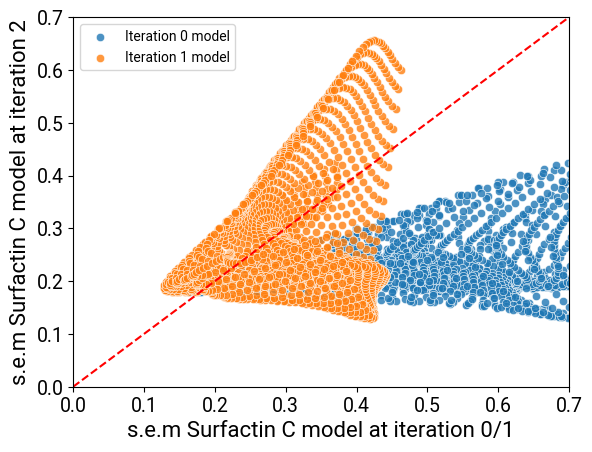

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()

# Increasing the size of tick labels
ax.tick_params(axis='both', which='major', labelsize=14)

# Scatter plots
sns.scatterplot(data=devi, x="model_0", y="model_2", ax=ax, label="Iteration 0 model",alpha=0.8)
sns.scatterplot(data=devi, x="model_1", y="model_2", ax=ax, label="Iteration 1 model",alpha=0.8)

# Setting the labels with increased font size
ax.set_xlabel('s.e.m Surfactin C model at iteration 0/1', fontsize=16)
ax.set_ylabel('s.e.m Surfactin C model at iteration 2', fontsize=16)

# Setting the limits
ax.set_xlim(0,0.7)
ax.set_ylim(0,0.7)

# Drawing a diagonal
ax.plot([0, 0.7], [0, 0.7], color='red', linestyle='--')

# Legend
ax.legend()

# Saving the figure
#plt.savefig("semplot_SurfactinC_iterations.jpg", bbox_inches="tight", dpi=400)

# Display the plot
plt.show()  

In [36]:
plt.close()

In [37]:
df=forpca.copy()
#df=df.drop("SurfactinC",axis=1)
#dftmp=pd.concat([forpca,intpcacomp])
dftmp=df.rename({"R-2,3-dihydroxy-3-methylpentanoate":'R-2,3-DH-3-MP','R-2,3-Dihydroxy-isovalerate':'R-2,3-DH-isovalerate'},axis=1)

In [38]:
dftmp

molecule,(S)-Malate,3-Phospho-D-glycerate,6-Phosphogluconic acid,Biotin,Butyrate,Citrate,D-Fructose 6-phosphate,Isocitrate,IturinA,L-Arginine,...,L-Tryptophan,L-Valine,Last_OD,Max_OD,"R-2,3-DH-isovalerate","R-2,3-DH-3-MP",Succinate,SurfactinB,SurfactinC,SurfactinD
arm_name,,,,,,,,,,,,,,,,,,,,,
0_1,0.637008,1.233695,1.892086,0.831996,0.361908,0.703735,1.498597,0.898743,0.428668,1.617498,...,0.848008,0.955538,0.833932,1.212274,2.538826,2.578909,0.337672,1.015201,1.004578,0.479060
0_2,1.391208,1.153458,1.225935,0.742170,0.864725,1.135996,1.332844,1.174799,1.990583,2.746895,...,0.696649,1.955703,1.094243,1.199787,1.857119,1.541427,1.052501,2.230028,2.629998,1.859999
0_3,1.326525,1.887847,1.490453,0.782313,0.576900,0.647943,1.167464,0.905186,0.105443,7.565361,...,0.701184,2.449443,1.048705,1.207669,2.596386,1.909279,0.634800,0.141245,0.259690,0.122054
0_4,1.128907,1.918625,1.528871,0.834267,0.441499,0.791429,1.104904,1.009774,1.166330,7.400230,...,0.721283,1.168124,0.891959,1.157899,2.357280,1.677992,0.662040,1.269865,1.586320,1.361227
0_5,1.535084,1.400548,0.516820,1.053663,1.073509,1.591018,0.861918,1.484885,1.576033,2.819068,...,0.879941,1.049761,0.984252,0.964045,0.875711,1.111165,1.343620,1.446648,1.648880,1.879997
0_6,1.367896,2.791209,1.485867,1.128072,0.514478,0.821103,1.451758,1.012292,0.477382,8.495177,...,1.017489,1.799417,1.007524,1.246900,2.459515,1.665564,0.813961,0.393469,0.630444,0.631132
0_7,1.266340,1.740408,0.990872,0.646363,0.775856,1.161424,1.162325,1.271874,1.340322,3.520894,...,0.586645,2.010594,0.783552,0.981550,1.462625,1.104485,0.792982,1.084866,1.324136,1.268054
1_1,0.596713,0.807512,1.684277,0.601880,0.346140,0.704509,1.591619,0.726874,1.451152,0.688175,...,0.708532,1.037429,0.707745,1.124535,1.731521,1.294833,0.429258,1.808079,1.744168,1.662427
1_2,1.626781,1.227213,1.490089,0.743067,0.579112,1.145301,1.583588,1.104773,1.374837,2.290532,...,0.696013,1.340513,1.038581,1.168776,1.617193,1.898646,1.028578,1.193642,1.279926,1.288672


In [39]:
dftmp.to_csv("raw_data_correlation_plot.csv")

In [40]:
plt.close()

/home/rgvalenciaalbornoz/miniconda3/envs/boaxlatest/lib/python3.10/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


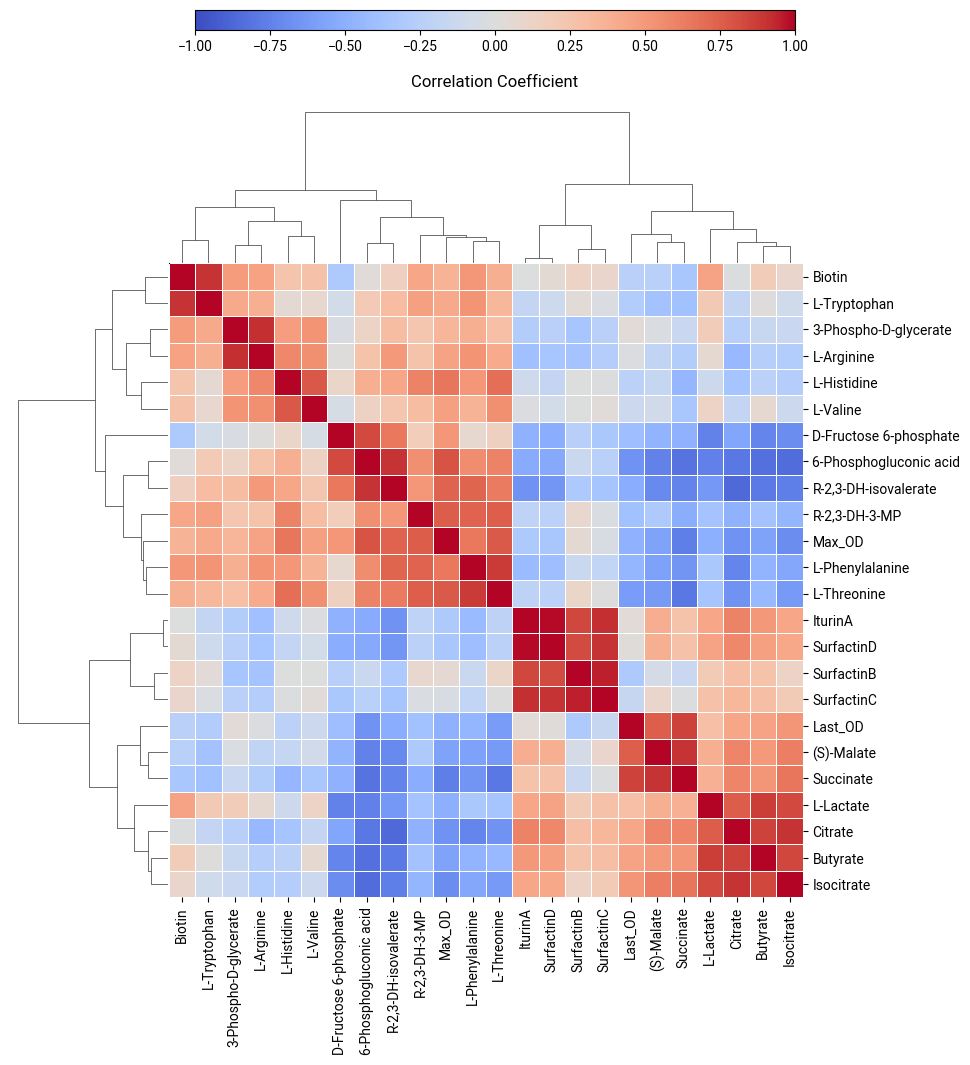

In [41]:
# Load the data
data = dftmp

corrdata=data.corr()

# Generate a clustermap with a more divergent color scheme (coolwarm)
cluster_grid = sns.clustermap(corrdata, cmap="coolwarm", vmax=1.0, vmin=-1.0, center=0,
                              square=True, linewidths=.5, cbar_pos=None)

ax=cluster_grid.ax_heatmap
ax.set_xlabel("")
ax.set_ylabel("")

ax.plot([0, 0], [0, 0], color='black')
ax.plot([0, -0.5], [0,0], color='black')
ax.plot([0, -0.5], [0,0], color='black')
# Create a custom color bar at the top
norm = plt.Normalize(-1.0, 1.0)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])

# Add color bar at the top with more space to avoid overlapping with the dendrogram and label
cbar_ax = cluster_grid.fig.add_axes([0.2, 1.06, 0.6, 0.02])  # Adjust the position and dimensions of the color bar
cbar = cluster_grid.fig.colorbar(sm, orientation="horizontal", cax=cbar_ax)
cbar.set_label('Correlation Coefficient', labelpad=15, y=1.6, fontsize=12)

# Save the plot to a file
#cluster_grid.fig.savefig('path/to/save/your/plot.png')

# Show the plot
plt.show()

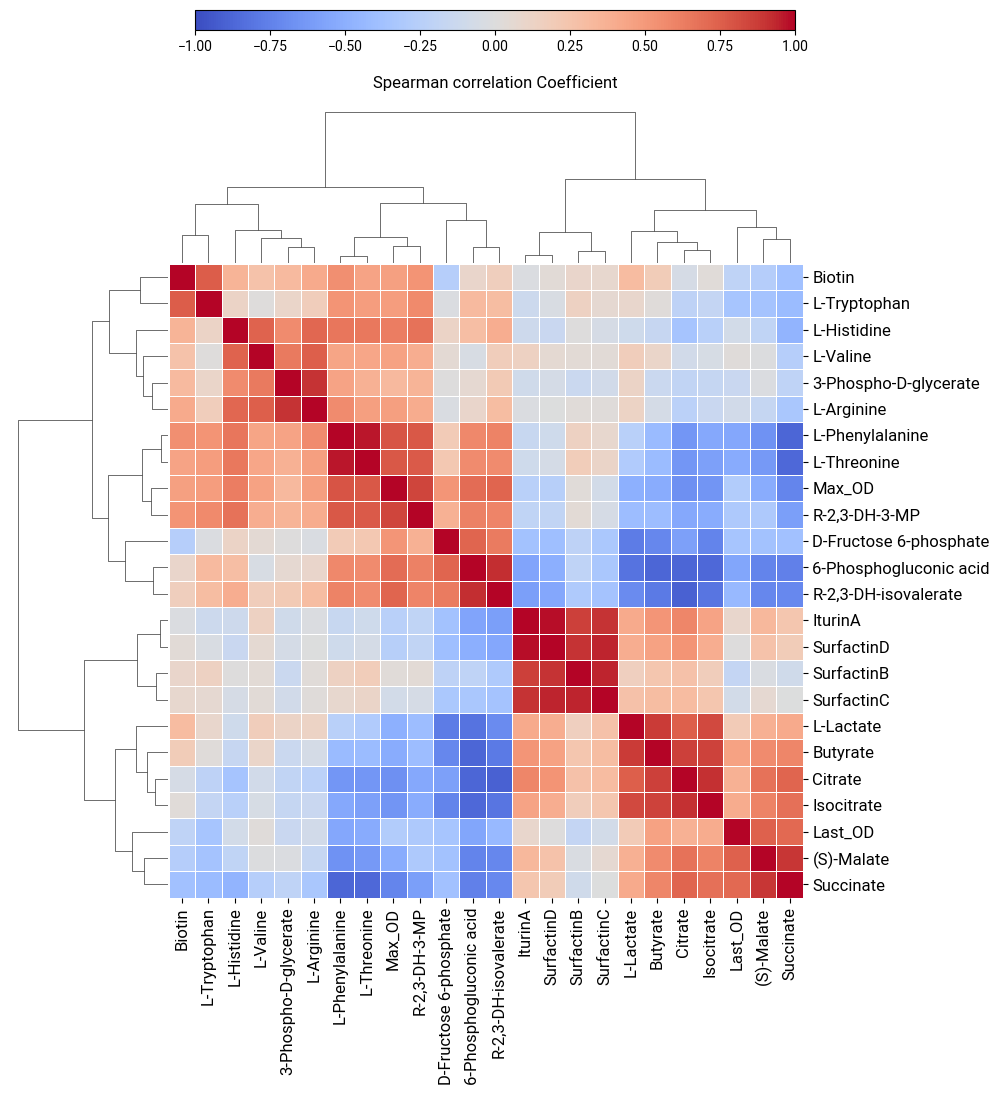

In [42]:
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
# Load the data
data = dftmp

corrdata=data.corr(method="spearman")

# Generate a clustermap with a more divergent color scheme (coolwarm)
cluster_grid = sns.clustermap(corrdata, cmap="coolwarm", vmax=1.0, vmin=-1.0, center=0,
                              square=True, linewidths=.5, cbar_pos=None)
ax=cluster_grid.ax_heatmap
ax.set_xlabel("")
ax.set_ylabel("")

ax.tick_params(axis='both', which='both', labelsize=12)

# Create a custom color bar at the top
norm = plt.Normalize(-1.0, 1.0)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])

# Add color bar at the top with more space to avoid overlapping with the dendrogram and label
cbar_ax = cluster_grid.fig.add_axes([0.2, 1.06, 0.6, 0.02])  # Adjust the position and dimensions of the color bar
cbar = cluster_grid.fig.colorbar(sm, orientation="horizontal", cax=cbar_ax)
cbar.set_label('Spearman correlation Coefficient', labelpad=15, y=1.6, fontsize=12)

# Save the plot to a file
plt.savefig('correlation_plot.png',bbox_inches="tight",transparent=True,dpi=200)

# Show the plot
#plt.tight_layout()
plt.show()

In [43]:
abbrev={'IturinA':'IturinA', 'SurfactinB':'SurfactinB', 'SurfactinC':'SurfactinC', 'SurfactinD':'SurfactinD', '(S)-Malate':'(S)-Malate',
       '3-Phospho-D-glycerate':'3-P-D-glycerate', '6-Phosphogluconic acid':'6-PG acid', 'Biotin':'Biotin', 'Butyrate':'Butyrate',
       'Citrate':'Citrate', 'D-Fructose 6-phosphate':'D-F-6-phosphate', 'Isocitrate':'Isocitrate', 'L-Arginine':'L-Arg',
       'L-Histidine':'L-His', 'L-Lactate':'L-Lactate', 'L-Phenylalanine':'L-Phe', 'L-Threonine':'L-Thr',
       'L-Tryptophan':'L-Trp', 'L-Valine':'L-Val', 'R-2,3-Dihydroxy-isovalerate':'R-2,3-DH-isovalerate',
       'R-2,3-dihydroxy-3-methylpentanoate':'R-2,3-DH-3-MP', 'Succinate':'Succinate','Last_OD':'Last_OD','Max_OD':'Max_OD'}

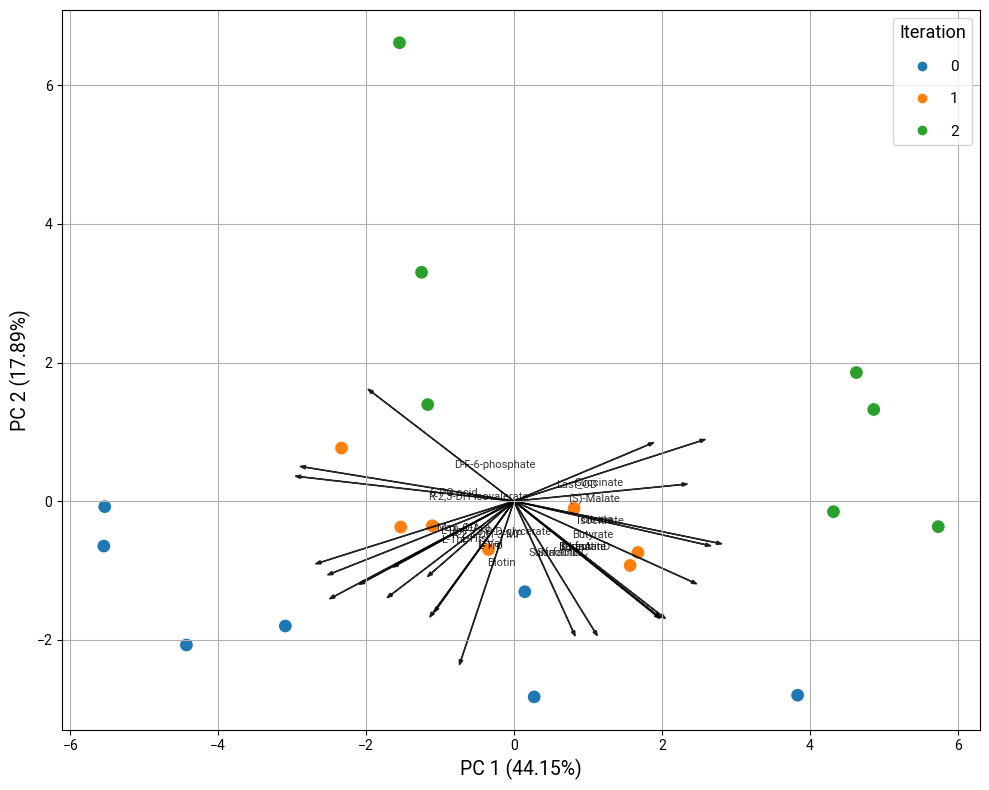

In [44]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load the data
data_path = 'raw_data_correlation_plot.csv'
data = pd.read_csv(data_path)

# Extract the iteration number from the "arm_name" column
data['iteration'] = data['arm_name'].str[0].astype(int)

# Separate the numerical data
numerical_data = data.drop(columns=['arm_name', 'iteration'])

# Standardize the numerical data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_data)

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)


# Get the PCA loadings
#loadings = pca.components_

# Retrieve the loading scores for each principal component
loading_scores = pca.components_.T * np.sqrt(pca.explained_variance_)
# Convert the PCA result to a dataframe and add the iteration column
pca_df = pd.DataFrame(data = pca_result, columns = ['principal component 1', 'principal component 2'])
pca_df['iteration'] = data['iteration']

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw a scatter plot with points colored based on the iteration number, using more divergent colors and circle markers
scatter_plot = sns.scatterplot(x='principal component 1', y='principal component 2', hue='iteration', data=pca_df, palette='tab10', s=100, marker='o', legend=False)

for i, col in enumerate(df.columns):
    plt.arrow(0, 0, loading_scores[i, 0]*3, loading_scores[i, 1]*3, color='black', width=0.005, head_width=0.05, alpha=0.8)
    plt.text(loading_scores[i, 0]* 1.1-0.1, loading_scores[i, 1] * 1.1-0.1, abbrev[col], color='black', fontsize=8, alpha=0.8)

# Set plot title and labels with explained variance ratio
plt.title('', fontsize=16)
plt.xlabel(f'PC 1 ({explained_variance_ratio[0]*100:.2f}%)', fontsize=14)
plt.ylabel(f'PC 2 ({explained_variance_ratio[1]*100:.2f}%)', fontsize=14)

# Create custom legend
legend_labels = sorted(pca_df['iteration'].unique())
legend_handles = [Line2D([0], [0], marker='o', color='w', label=str(lbl), markersize=8, markerfacecolor=sns.color_palette('tab10', n_colors=len(legend_labels))[i]) for i, lbl in enumerate(legend_labels)]
plt.legend(handles=legend_handles, title='Iteration', title_fontsize='13', labelspacing=1.2, fontsize='11')

plt.grid()
# Display the plot
plt.tight_layout()
plt.show()


In [50]:
plt.close()

In [60]:
colors = np.array([
    [0, 0, 255],  # Blue:   R=0, G=0, B=255
    [255, 165, 0],  # Orange: R=255, G=165, B=0
    [0, 255, 0]   # Green:  R=0, G=255, B=0
])

[scatterd] >INFO> Create scatterplot


[pca] >The PCA reduction is performed on the [24] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
[pca] >Plot PC1 vs PC2 with loadings.


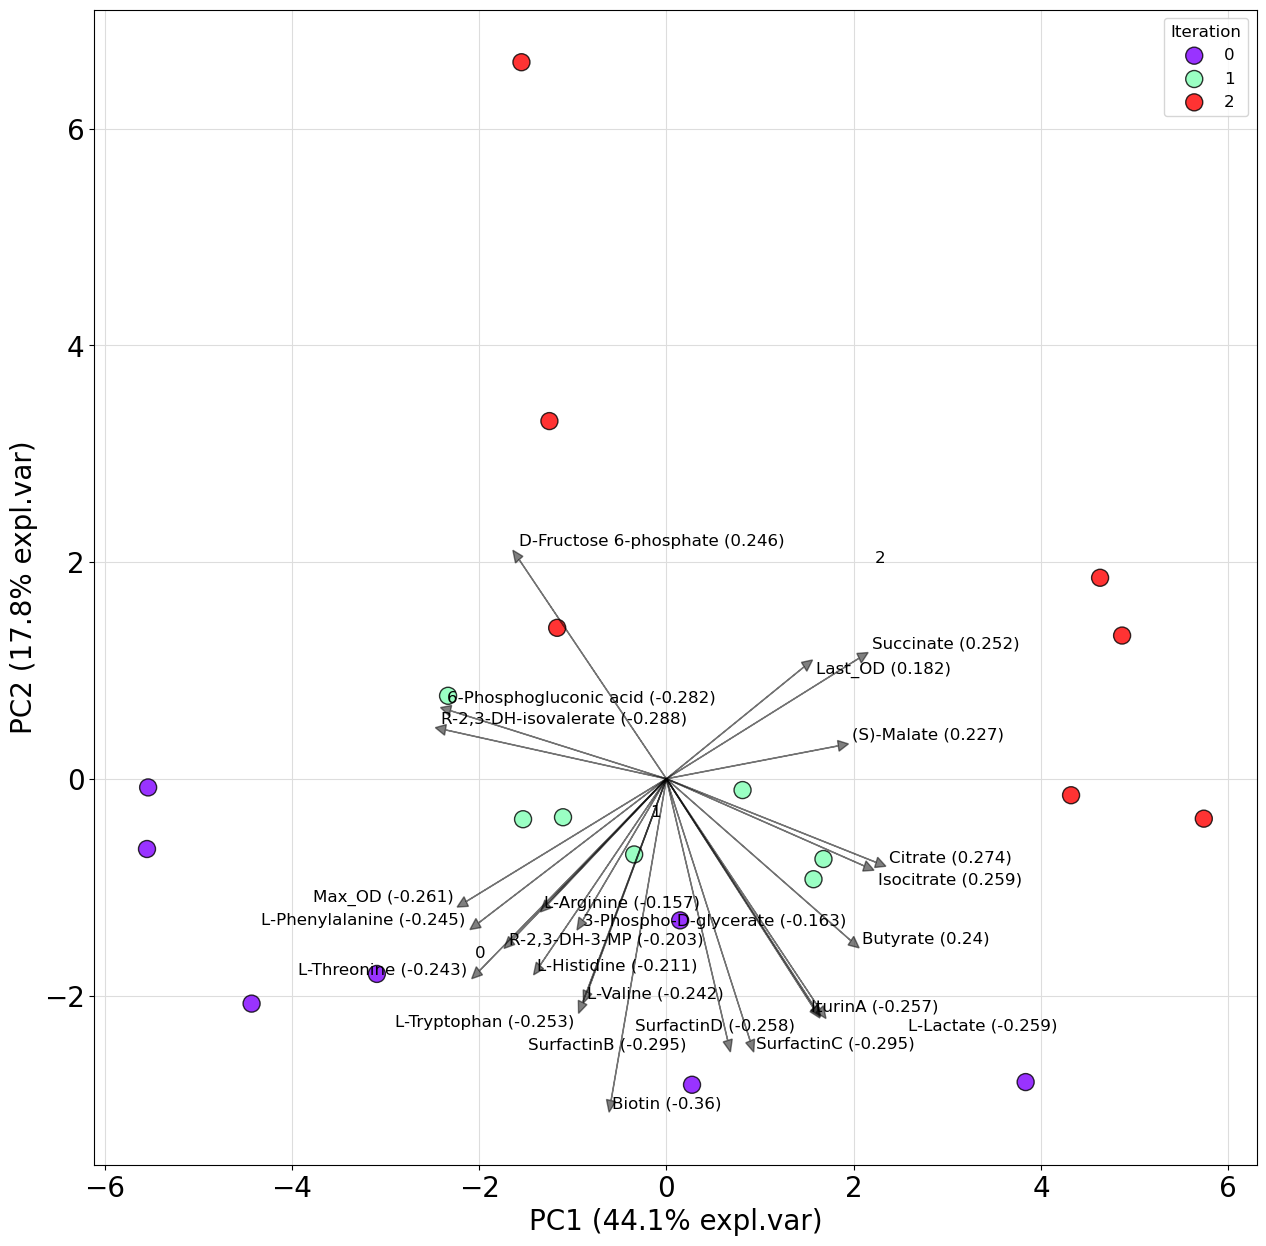

In [72]:
from pca import pca

model = pca(n_components=2)

# Fit and transform
results = model.fit_transform(X=scaled_data, row_labels=data["iteration"],col_labels=list(numerical_data.columns))

# Plot the explained variance
#fig, ax = model.plot()

# Scatter the first two PCs
#fig, ax = model.scatter()

# Create a biplot
fig, ax = model.biplot(n_feat=24,figsize=(15,15),cmap="rainbow",color_arrow="#000000",fontsize=12,arrowdict={"color_text":"#000000","alpha":0.5})

# Adding a title to the legend
ax.legend(title="Iteration")

# Adding a plot title
ax.set_title("")
leg = ax.get_legend()

plt.savefig("biplot.svg",dpi=200,transparent=True,bbox_inches="tight")
plt.show()

In [62]:
pca_result

array([[-5.53444411, -0.07970334],
       [ 0.27370972, -2.82380876],
       [-5.54666189, -0.64802839],
       [-3.09215476, -1.80092417],
       [ 3.83641994, -2.79897281],
       [-4.4296178 , -2.07491063],
       [ 0.14674265, -1.30652711],
       [-2.33157134,  0.76603438],
       [-1.10397781, -0.35497131],
       [ 0.81346673, -0.1041693 ],
       [ 1.67739018, -0.74029867],
       [-0.34432116, -0.69842506],
       [ 1.57090931, -0.92685617],
       [-1.53068351, -0.37317023],
       [-1.54791609,  6.61307623],
       [-1.16649814,  1.39309782],
       [ 4.86648045,  1.32195704],
       [ 4.63149913,  1.85517415],
       [ 5.7390745 , -0.36797696],
       [-1.24928603,  3.30113621],
       [ 4.32144005, -0.15173291]])

In [64]:
pca.components_

array([[ 0.22720186, -0.11158453, -0.28189023, -0.07152125,  0.2404867 ,
         0.27388346, -0.19157803,  0.2590509 ,  0.19248189, -0.1572096 ,
        -0.16573764,  0.19912221, -0.24515521, -0.24294061, -0.10961832,
        -0.10347299,  0.18239051, -0.2611417 , -0.28831895, -0.20261794,
         0.25174797,  0.07987338,  0.10899511,  0.19154278],
       [ 0.03761255, -0.16311136,  0.07682399, -0.35957049, -0.18235615,
        -0.09432681,  0.24645195, -0.09863105, -0.25653244, -0.14365158,
        -0.21147246, -0.25852069, -0.16263142, -0.21560255, -0.25299173,
        -0.2416477 ,  0.1281651 , -0.13836403,  0.0551583 , -0.18296474,
         0.13616166, -0.29458786, -0.29472548, -0.25800104]])

In [45]:
len (list(abbrev.keys()))

24

In [55]:
print(model.results['topfeat'])

     PC                 feature   loading  type
0   PC1    R-2,3-DH-isovalerate -0.288319  best
1   PC2                  Biotin -0.359570  best
2   PC1              (S)-Malate  0.227202  weak
3   PC2   3-Phospho-D-glycerate -0.163111  weak
4   PC1  6-Phosphogluconic acid -0.281890  weak
5   PC1                Butyrate  0.240487  weak
6   PC1                 Citrate  0.273883  weak
7   PC2  D-Fructose 6-phosphate  0.246452  weak
8   PC1              Isocitrate  0.259051  weak
9   PC2                 IturinA -0.256532  weak
10  PC1              L-Arginine -0.157210  weak
11  PC2             L-Histidine -0.211472  weak
12  PC2               L-Lactate -0.258521  weak
13  PC1         L-Phenylalanine -0.245155  weak
14  PC1             L-Threonine -0.242941  weak
15  PC2            L-Tryptophan -0.252992  weak
16  PC2                L-Valine -0.241648  weak
17  PC1                 Last_OD  0.182391  weak
18  PC1                  Max_OD -0.261142  weak
19  PC1           R-2,3-DH-3-MP -0.20261